# Tracking muons with 4 Drift Tubes chambers setup

### Description

The project consist in the analysis of the data gathered by four drift-tubes detectors during a beam test aimed at the production of $\mu^+ - \mu^-$ pairs. This was achieved by shooting 45 GeV positrons on a Beryllium target. Most of the collisons yielded background events (e.g. Bhabha scattering events), whereas only a small fraction produced an actual muons pair. A signal event would consist of two tracks, each traversing two muon detectors (as a dipole magnet deflected in different directions the positively and the negatively charged particles).

The following figure displays a signal event. It is possible to notice the positioning of the four drift-tubes detectors. Particles are moving essentially along the $z$ axis (the beam direction) while the bending due to the dipole magnet occures along the $x$ axis. The $y$ coordinate is irrelevant in this context as it was not measured. 
![alt text](./Figure_1228.png)


Calibration runs were taken too, by shouting directly positive muons at a given energy on the target, e.g. they consist of single tracks on either of the two sides of the apparatus as shown in the following picture. Which side of the apparatus was determined by the sign of the current powering the magnet.

![alt text](./Figure_r261_19.png)

Each detector consists of four layers of drift-tubes, i.e. cells with an anodic wire at the center and cathods at the sides filled up with a gas mixture of ${\rm Ar-CO_2}$ ($85\%-15\%$). The passage of a charged particle through a cell would ionize the gas, with a consequent drift of electrons towards the anodic wire. Exploiting a linear relation (the drift velocity inside the cell is constant), by measuring the time of arrival of the primary ionization, it is possible to reconstruct the track's position within the cell. Note that there is a left-right ambiguity in the determination of the position (blue-red dots in the display).

The following picture shows the hits left by the muons passing through one fo the detectors (the straight lines represent fits to the recorded hits, we will come to that later). The anodic wires (not drawn) sit at the center of the cells.
![alt text](./Figure_1228_zoom.png)

As it can be seen, the layers are staggered by half a cell.

The relevant dimensions and the overall coordinate transformations in $z$ and $x$ are given below. Note that all the quantities are expressed in $mm$. 

In [1]:
# Cell dimensions
XCELL = 42.
ZCELL = 13.

# X coordinates translation
global_x_shifts = [994.2, 947.4,-267.4,-261.5,]

# Z coordinates translations
#la prima mi serve a riscalare le z in base alla cella in cui passa
#la seconda serve a riscalare le z in base al detector in cui passa
local_z_shifts = [z*ZCELL for z  in range(0,4)]
global_z_shifts = [823.5, 0, 823.5, 0]

print(local_z_shifts)

### Datasets

In your assigned VM (LCP-6, IP: 10.67.22.15) you find the relevant datasets on `\data`. There are two folders where data for the physics runs and the calibration runs are stored. 

#### Calibration runs

In the following table the relevant parameters for the calibration runs are listed

| Run |  Energy (GeV)|  Magnet current (A)|
|-----|:---:|:-----:|
| 260 | 22 | -580 |
| 261 | 18 | -850 |
| 262 | 18 |  850 |
| 263 | 22 |  580 |

#### Physics runs

All physics runs were taken in the same conditions. They could be merged to gather more statistics (be reminded that $\mu^+ - \mu^-$ are very rare)


#### Data format

The data files are organized as a series of events (rows) where each event consist of the coordinates of the hits recorded in that event (N.B.: as the number of hits for even is not fixed, the dataset cannot be seen as a unique big table with a defined number of "columns"). More specifically every raw consists of:

* event number
* number of recorded hits (N)
* hit 1 coordinates
* ...
* hit N coordinates

where N could be zero too and the hits coordinates are: 
* *chamber*, which of the four detector registered the hit (numbering is in the range $0-4$)
* *layer*, which layer of that detector
* *xleft*, the x position of the hit **in the local detector coordinates** assuming the track passed at the left of the wire
* *xright*, the x position of the hit **in the local detector coordinates** assuming the track passed at the right of the wire
* *time*, the drift time (redundant)

The local detector coordinates are defined with respect to one side (the left one) of the detector. All the detectors however were placed rotated by 180 degrees, i.e. the x axes of the local and global coordinates have different orientation.


### Assignments

The goal of the analysis is to select and study events with muon(s) passing through the detectors.
You can start looking at the calibration runs as most of those events consist of muon tracks.

Suggestion to be followed: for every event create a Pandas DataFrame with the hits recorded in that event. Add columns (features) as needed (e.g. global coordinates)

* Process the data and place the hits approriately in the global $xz$ plane (e.g. transform local coordinates into global coordinates)
* Display (event-by-event) the four detectors, the hits and the cell where the hits are found
* Select good (calibration) events by requiring hits either on the left side (detectors 0 and 1) or on the right side (detectors 2 and 3)
* Perform a local linear fit of the hits in each detector, for the cases where at least 3 hits in 3 different layers are found
* Perform a global linear fit combining the hits of 2 detectors on either of the two sides of the apparatus
* Study the performances of the detectors? What is the hit efficiency? What is the resolution of the position measurement?  
* Add the result of the fits to the event display (you should get what is shown in the picuters above, where the dashed lines correspond to the local fits and the solid line to the global one)
* Repeat what done above for the physics runs; start by selecting good physics events. Muon tracks hits were expected in the following regions for the 4 detectors:
```python
{0:[540.,720.],1:[540.,720],2:[0.,200.],3:[0.,200.]}
```
what other requirements should you apply?
* Study the proporeties of the signal events: number of events, angular distributions and their correlations, etc. 

### Contacts

* Marco Zanetti <marco.zanetti@unipd.it>
* Jacopo Pazzini <jacopo.pazzini@unipd.it>


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from os import listdir
%matplotlib inline
from itertools import combinations
import random
from scipy import stats

In [3]:
data_file ="/Users/federicob/Documents/data/calibration/Run000260/data_000000.txt"
run=[]
with open(data_file) as f:
    for line in f:
        event = line.split()
        event = [float(i) for i in event]
        run.append(event)
print()

In [4]:




'''tale funzione prede in input lo indirizzo della locazione delle cartelle e ritorna un numpy array avente come 
elementi i singoli eventi già reshape-ati, un sempio di elemento è: 

array([[  2. ,   3. , 355. , 359. ,  36.7],
       [  2. ,   1. , 355.3, 358.7,  30.8],
       [  2. ,   4. , 316. , 356. , 371.7],
       [  3. ,   2. , 327.4, 344.6, 160. ],
       [  3. ,   1. , 343.9, 370.1, 243.3],
       [  3. ,   4. , 328. , 344. , 149.2],
       [  3. ,   3. , 344.4, 369.6, 233.3]])
       
le colonne sono rispettivamente: 
|chamber | layer | xleft | xright | time |'''

'''def opener(indirizzo_cartella):
    
    mypath = indirizzo_cartella
    files = [f for f in listdir(mypath)]
    
    dati=[]
    
    for j in range(len(files)):
        datafile=indirizzo_cartella+"/"+files[j]
        with open(datafile) as f:
            content = f.readlines()
        data=np.array(content)

        for i in range(len(data)):
            A=np.array(data[i].split(' '))
            A = A.astype(np.float)
            if A[1]!=0:
                B=A[2::]
                B=B.reshape(int(A[1]),int(len(B)/A[1]))
                dati.append(B)
            elif A[1]==0:
                dati.append([0])
    dati=np.array(dati)
    return(dati)'''

'def opener(indirizzo_cartella):\n    \n    mypath = indirizzo_cartella\n    files = [f for f in listdir(mypath)]\n    \n    dati=[]\n    \n    for j in range(len(files)):\n        datafile=indirizzo_cartella+"/"+files[j]\n        with open(datafile) as f:\n            content = f.readlines()\n        data=np.array(content)\n\n        for i in range(len(data)):\n            A=np.array(data[i].split(\' \'))\n            A = A.astype(np.float)\n            if A[1]!=0:\n                B=A[2::]\n                B=B.reshape(int(A[1]),int(len(B)/A[1]))\n                dati.append(B)\n            elif A[1]==0:\n                dati.append([0])\n    dati=np.array(dati)\n    return(dati)'

In [ ]:
'''data=opener("/Users/federicob/Documents/data/calibration/Run000260")

data'''

'data=opener("/Users/federicob/Documents/data/calibration/Run000260")\n\ndata'

In [ ]:
# Cell dimensions
XCELL = 42.
ZCELL = 13.

# X coordinates translation
global_x_shifts = [994.2, 947.4,-267.4,-261.5,]

# Z coordinates translations
local_z_shifts = [z*ZCELL for z in range(0,4)]
global_z_shifts = [823.5, 0, 823.5, 0]

'''for i in listdir("/Users/federicob/Documents/data/calibration/Run000260"):
    file="/Users/federicob/Documents/data/calibration/Run000260"+"/"+i
    with open(file) as f:
        for line in f:
            event = line.split()
            event = [float(i) for i in event]
            event_number = int(event[0])
            hits_number  = int(event[1])
            hit       = np.arange(hits_number)
            chamber   = np.fromiter((event[2+5*i] for i in range(hits_number)), int)
            layer     = np.fromiter((event[3+5*i] for i in range(hits_number)), int)
            xl_local  = np.fromiter((event[4+5*i] for i in range(hits_number)), float)
            xr_local  = np.fromiter((event[5+5*i] for i in range(hits_number)), float)
            z_local   = np.fromiter((local_z_shifts[i-1]+ZCELL/2 for i in layer), float)
            time      = np.fromiter((event[6+5*i] for i in range(hits_number)), float)
            xl_global = np.fromiter((global_x_shifts[i] for i in chamber), float) - xl_local
            xr_global = np.fromiter((global_x_shifts[i] for i in chamber), float) - xr_local
            z_global  = np.fromiter((global_z_shifts[i] for i in chamber), float) + z_local
            dataframe = pd.DataFrame(
                { 'EvNumber' : event_number,
                  'Hit'      : hit,
                  'Chamber'  : chamber,
                  'Layer'    : layer,
                  'XL_local' : xl_local,
                  'XR_local' : xr_local,
                  'Z_local'  : z_local,
                  'Time'     : time,
                  'XL_global': xl_global,
                  'XR_global': xr_global,
                  'Z_global' : z_global,
                })
            #dataframe.set_index('Hit', inplace=True) # set as index the number of the hit
            #print(dataframe)
            for j in range(0,4):
                dataframe1=dataframe.loc[dataframe['Chamber'] == j] #in questo modo ottengo un dataframe per ogni evento e chamber
                #print(dataframe1)
                unici=dataframe1['Layer'].nunique() 
                if unici>=3: #mi assicuro che ci siano almeno 3 hit in 3 layer diversi
                    xl=np.array(dataframe1['XL_local'])
                    #print(xl)
                    xr=np.array(dataframe1['XR_local'])
                    #print(xr)
                    z=np.array(dataframe1['Z_local'])
                    #print(z)
                    
                    puntir=[]
                    for j in range(0,np.shape(z)[0]):
                        puntir.append((z[j],xr[j]))
                    #print(puntir)
                    puntil=[]
                    for j in range(0,np.shape(z)[0]):
                        puntil.append((z[j],xl[j]))
                    #print(puntil)
                    layer1=[]
                    layer2=[]
                    layer3=[]
                    layer4=[]
                    for j in puntil:
                        if j[0]==6.5:
                            layer1.append(j)
                        elif j[0]==19.5:
                            layer2.append(j)
                        elif j[0]==32.5:
                            layer3.append(j)
                        elif j[0]==45.5:
                            layer4.append(j)
                    for j in puntir:
                        if j[0]==6.5:
                            layer1.append(j)
                        elif j[0]==19.5:
                            layer2.append(j)
                        elif j[0]==32.5:
                            layer3.append(j)
                        elif j[0]==45.5:
                            layer4.append(j)
                    #print(layer1)
                    #print(layer2)
                    #print(layer3)
                    #print(layer4)
                    if unici==3: #PER CREARE LE COMBINAZIONI CON 3 ELEMENTI
                        if len(layer1)==0:
                            combinazioni=np.array([(x,y,z) for x in layer2 for y in layer3 for z in layer4])
                        elif len(layer2)==0:
                            combinazioni=np.array([(x,y,z) for x in layer1 for y in layer3 for z in layer4])
                        elif len(layer3)==0:
                            combinazioni=np.array([(x,y,z) for x in layer1 for y in layer2 for z in layer4])
                        elif len(layer4)==0:
                            combinazioni=np.array([(x,y,z) for x in layer1 for y in layer2 for z in layer3])
                        #print(combinazioni)
                        chimin=1000
                        punti=0
                        coeff=np.zeros((2, 3))
                        for i in combinazioni: #PER OGNI COMBINAZIONE FACCIO IL FIT, CALCOLO IL CHI^2 E PLOTTO SOLO LA COMBINAZIONE CON IL CHI MINORE
                            p=np.polyfit(i[:,0], i[:,1], 1) #calcolo coeff ZANETTI AVEVA DETTO DI FARE x(z)
                            #print("coefficienti fit:",p)
                            chi_squared=np.sum(((np.polyval(p, i[:,0]) - i[:,1]) ** 2)) #calcolo chi2
                            #print("chiquadro:",chi_squared)
                            if chi_squared<chimin: #trovo il chi minore e salvo la combianzione e i parametri ad esso associato
                                chimin=chi_squared
                                punti=i
                                coeff=p
                                print(coeff)
                        print("coefficiente migliore:", coeff)
                        #print(type(coeff), type(coeff.item(0)), type(coeff.item(0)))
                        print("Chi^2 migliore:",chimin)
                        x=np.linspace(0,50,50)
                        y=coeff.item(0)*x + coeff.item(1)
                        #print("retta interpolante:",y)
                        plt.figure()
                        plt.plot(punti[:,1], punti[:,0],"o",label='original data')
                        plt.plot(y,x,"-",label="fitted data")
                        plt.xlabel("x [mm]")
                        plt.ylabel("z [mm]")
                        plt.title(punti) #DA SISTEMARE IL TITOLO    
                        plt.grid(True)
                        plt.show()
                    elif unici==4: #PER CREARE LE COMBINAZIONI CON 4 ELEMENTI
                        combinazioni=np.array([(x,y,z,w) for x in layer1 for y in layer2 for z in layer3 for w in layer4])
                        #print(combinazioni)
                        chimin=1000
                        punti=0
                        coeff=coeff=np.zeros((2, 4))
                        for i in combinazioni: #PER OGNI COMBINAZIONE FACCIO IL FIT, CALCOLO IL CHI^2 E PLOTTO SOLO LA COMBINAZIONE CON IL CHI MINORE
                            p=np.polyfit(i[:,0], i[:,1], 1) #calcolo coeff
                            #print("coefficienti fit:",p)
                            chi_squared=np.sum(((np.polyval(p, i[:,0]) - i[:,1]) ** 2)) #calcolo chi2
                            #print("chiquadro:",chi_squared)
                            if chi_squared<chimin: #trovo il chi minore e salvo la combianzione e i parametri ad esso associato
                                chimin=chi_squared
                                punti=i
                                coeff=p
                        #print("coefficiente migliore:", coeff)
                        #print(type(coeff), type(coeff[0]), type(coeff[1]))
                        print("Chi^2 migliore:",chimin)
                        x=np.linspace(0,50,50)
                        y=coeff[0]*x + coeff[1]
                        #print("retta interpolante:",y)
                        plt.figure()
                        plt.plot(punti[:,1], punti[:,0],"o",label='original data')
                        plt.plot(y,x,"-",label="fitted data")
                        plt.xlabel("x [mm]")
                        plt.ylabel("z [mm]")
                        plt.title(punti) #DA SISTEMARE IL TITOLO    
                        plt.grid(True)
                        plt.show()'''

'for i in listdir("/Users/federicob/Documents/data/calibration/Run000260"):\n    file="/Users/federicob/Documents/data/calibration/Run000260"+"/"+i\n    with open(file) as f:\n        for line in f:\n            event = line.split()\n            event = [float(i) for i in event]\n            event_number = int(event[0])\n            hits_number  = int(event[1])\n            hit       = np.arange(hits_number)\n            chamber   = np.fromiter((event[2+5*i] for i in range(hits_number)), int)\n            layer     = np.fromiter((event[3+5*i] for i in range(hits_number)), int)\n            xl_local  = np.fromiter((event[4+5*i] for i in range(hits_number)), float)\n            xr_local  = np.fromiter((event[5+5*i] for i in range(hits_number)), float)\n            z_local   = np.fromiter((local_z_shifts[i-1]+ZCELL/2 for i in layer), float)\n            time      = np.fromiter((event[6+5*i] for i in range(hits_number)), float)\n            xl_global = np.fromiter((global_x_shifts[i] for i

[2, 3] [3, 4]
2


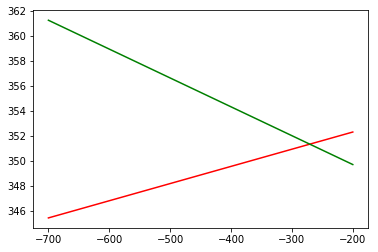

[2, 3] [4, 4]
2


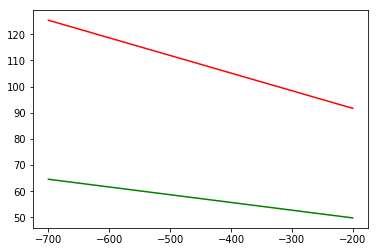

[2, 3] [4, 3]
2


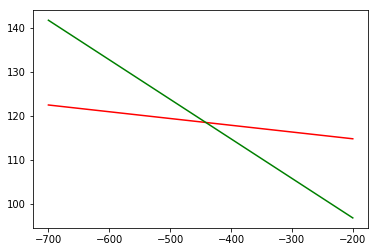

[2, 3] [3, 3]
2


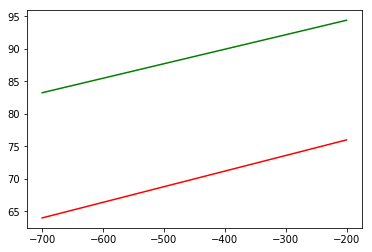

[2, 3] [4, 4]
2


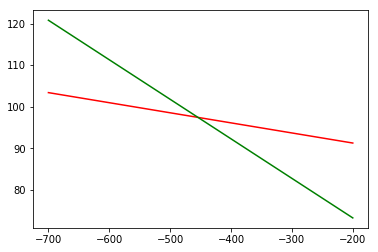

[2, 3] [4, 4]
2


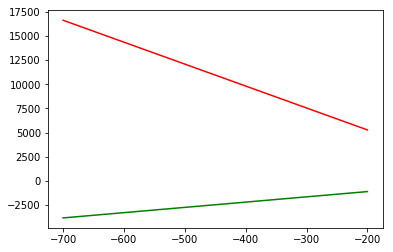

[2, 3] [4, 4]
2


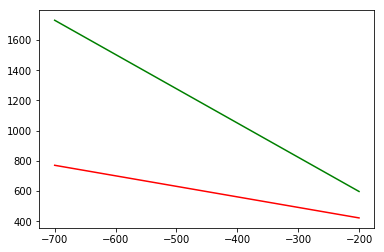

[0, 1] [4, 4]
0


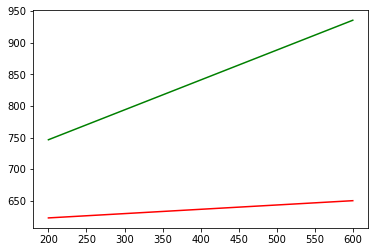

[2, 3] [3, 4]
2


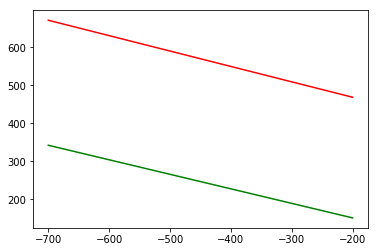

[2, 3] [4, 4]
2


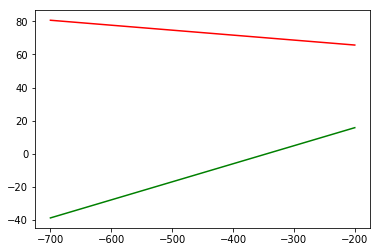

[2, 3] [4, 4]
2


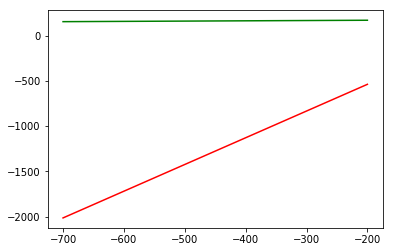

[2, 3] [4, 4]
2


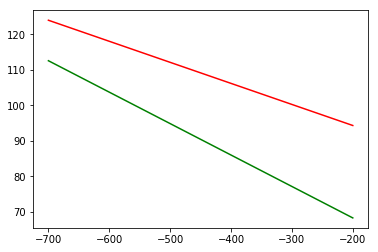

[2, 3] [4, 4]
2


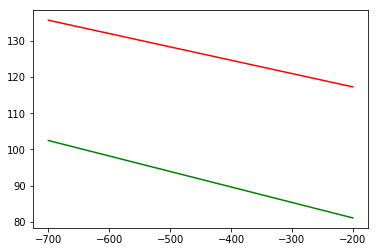

[2, 3] [4, 4]
2


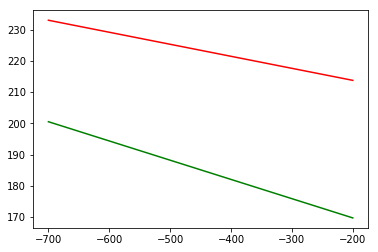

[2, 3] [4, 4]
2


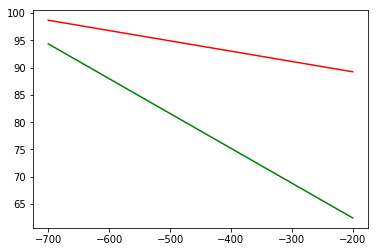

[2, 3] [4, 4]
2


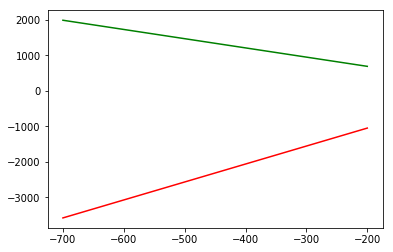

[2, 3] [4, 4]
2


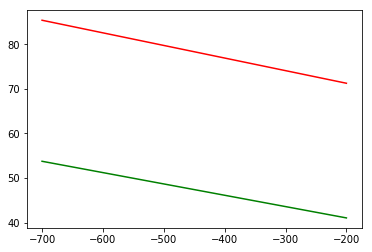

[2, 3] [4, 3]
2


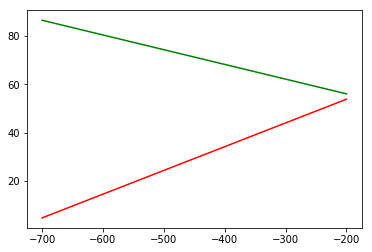

[2, 3] [4, 4]
2


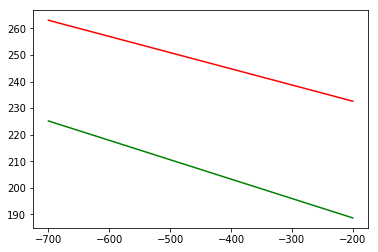

[2, 3] [4, 4]
2


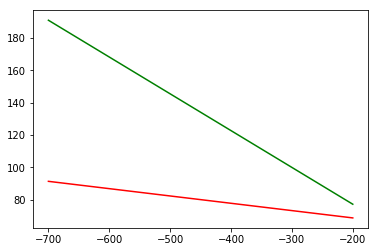

[2, 3] [4, 4]
2


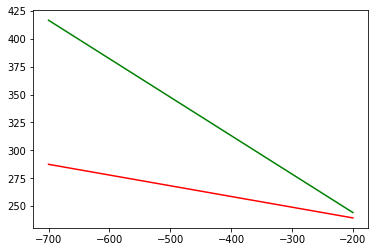

[2, 3] [4, 4]
2


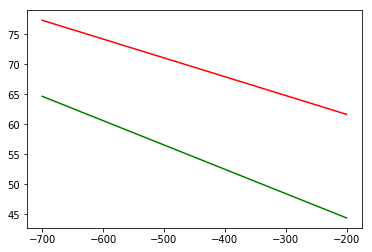

[2, 3] [4, 4]
2


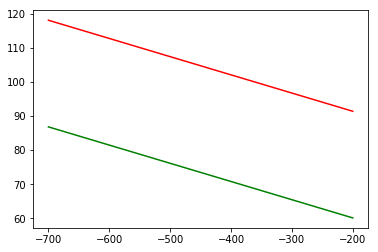

[2, 3] [3, 4]
2


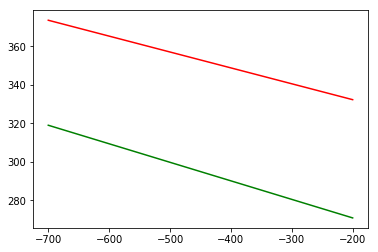

[2, 3] [3, 4]
2


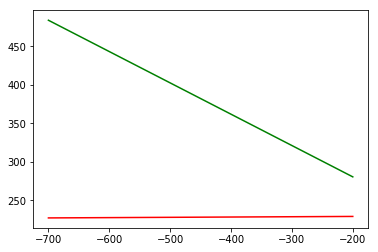

[2, 3] [4, 4]
2


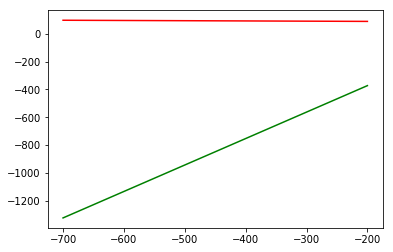

[2, 3] [4, 4]
2


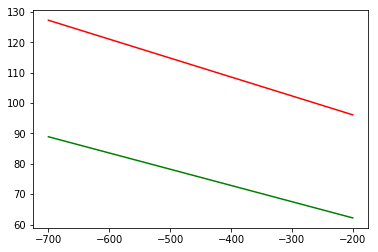

[2, 3] [3, 4]
2


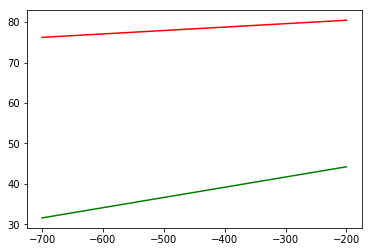

[2, 3] [4, 3]
2


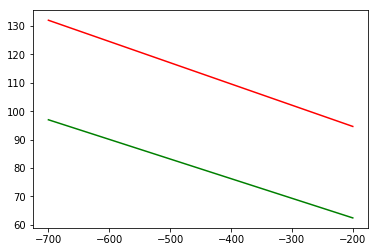

[2, 3] [3, 4]
2


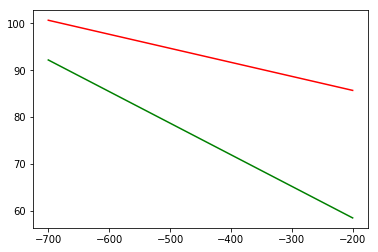

[2, 3] [4, 4]
2


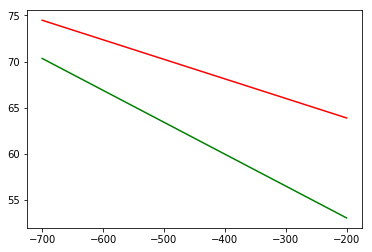

[2, 3] [3, 3]
2


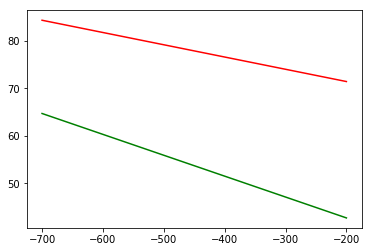

[2, 3] [4, 4]
2


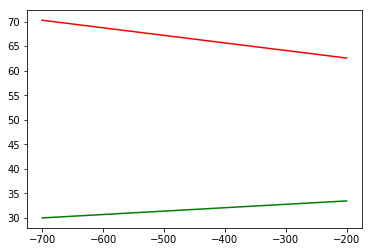

[0, 1] [4, 4]
0


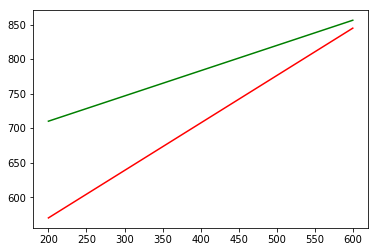

[2, 3] [4, 4]
2


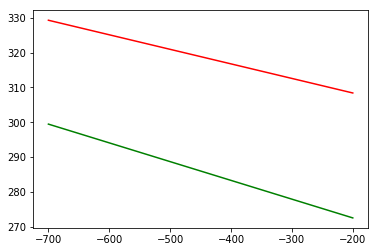

[2, 3] [4, 4]
2


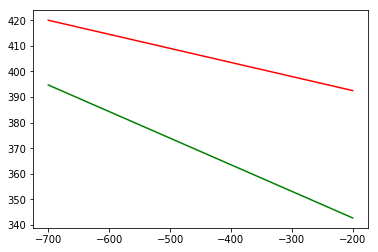

[0, 1] [4, 4]
0


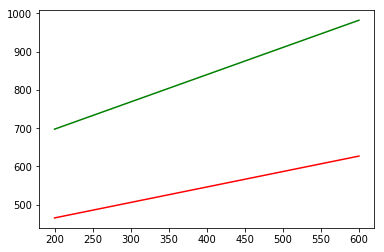

[2, 3] [4, 4]
2


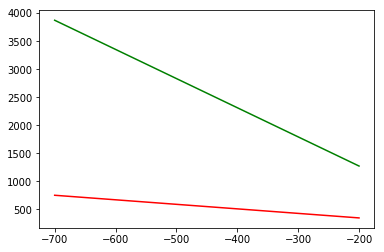

[2, 3] [4, 3]
2


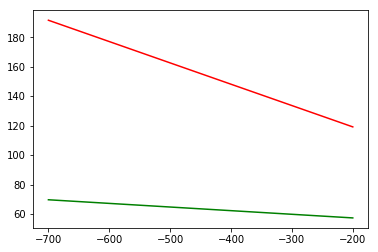

[2, 3] [4, 4]
2


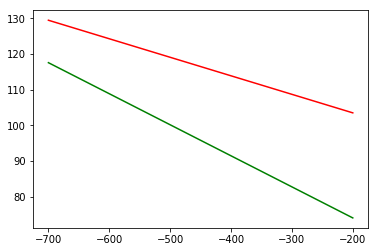

[0, 1] [4, 4]
0


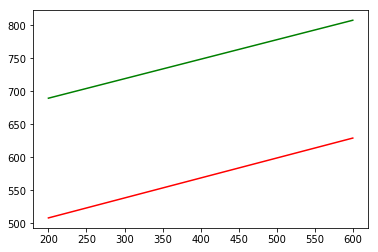

[2, 3] [4, 4]
2


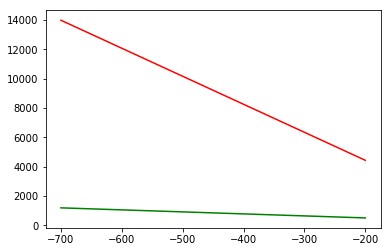

[2, 3] [4, 4]
2


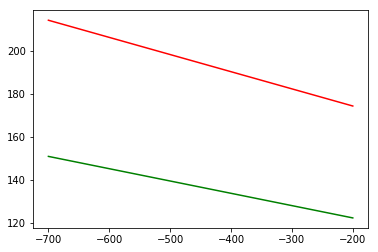

[2, 3] [4, 4]
2


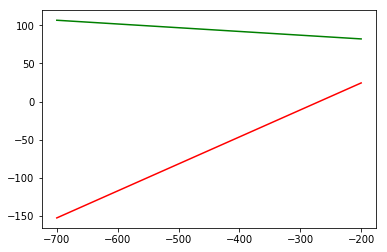

[2, 3] [4, 4]
2


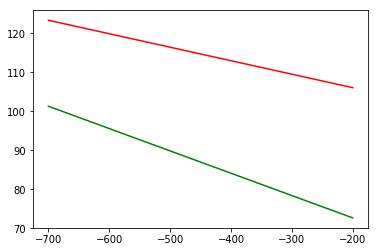

[2, 3] [3, 4]
2


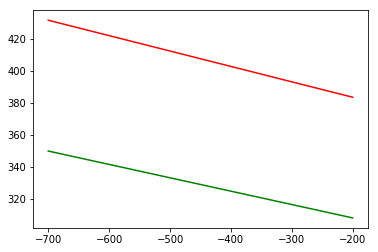

[2, 3] [3, 3]
2


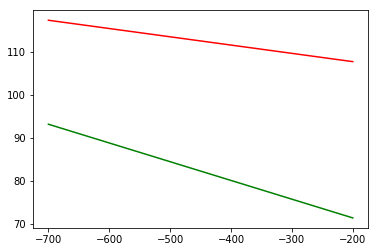

[2, 3] [4, 3]
2


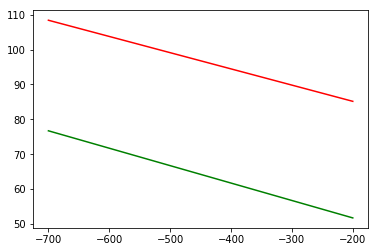

[2, 3] [4, 3]
2


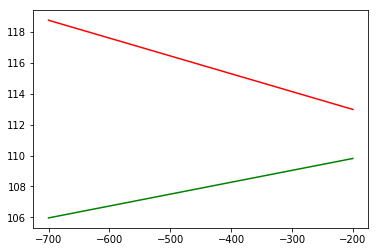

[2, 3] [3, 4]
2


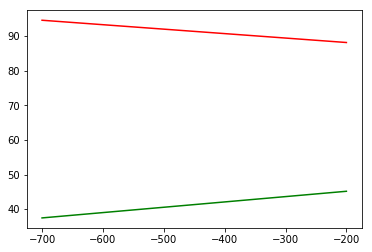

[2, 3] [4, 4]
2


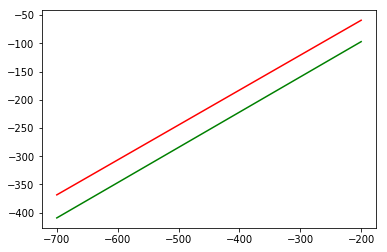

[2, 3] [4, 4]
2


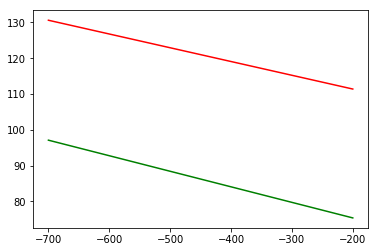

[2, 3] [4, 4]
2


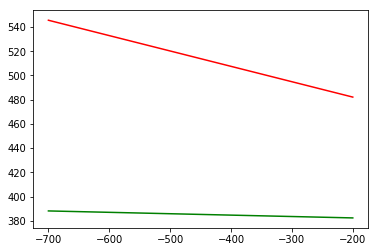

[2, 3] [4, 4]
2


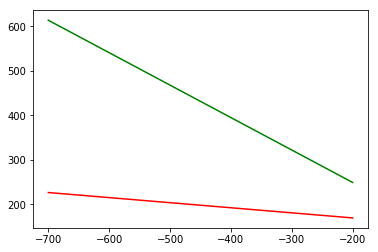

[2, 3] [3, 4]
2


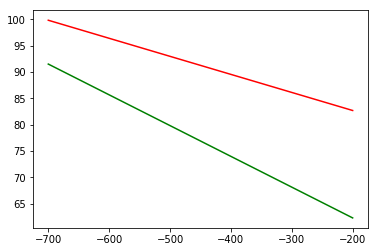

[2, 3] [4, 4]
2


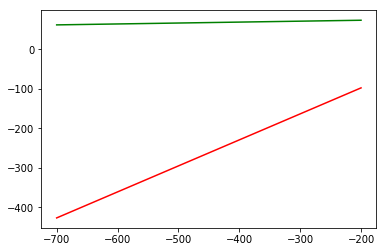

[2, 3] [4, 4]
2


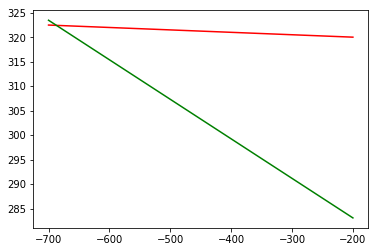

[2, 3] [4, 4]
2


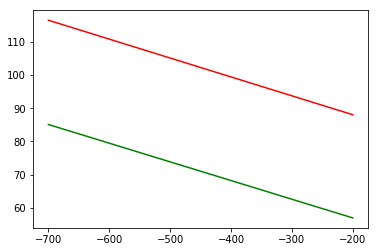

[2, 3] [4, 4]
2


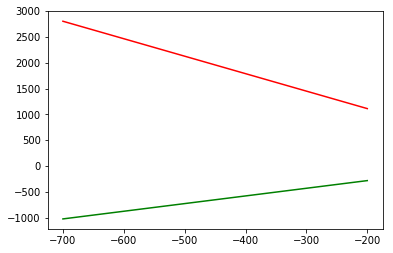

[2, 3] [4, 4]
2


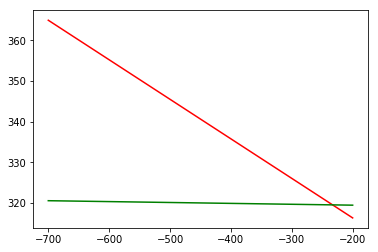

[2, 3] [4, 4]
2


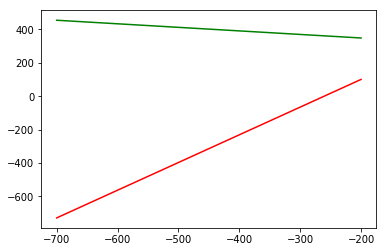

[2, 3] [4, 4]
2


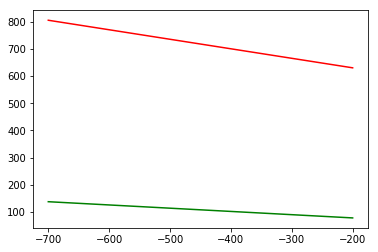

[2, 3] [4, 4]
2


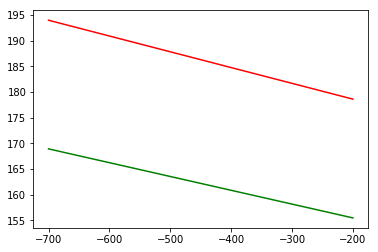

[2, 3] [4, 4]
2


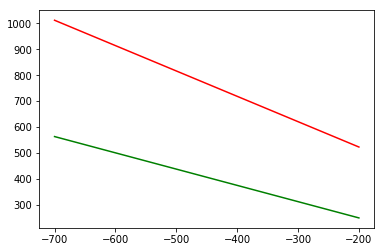

[2, 3] [4, 4]
2


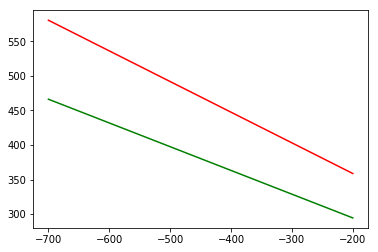

[2, 3] [4, 4]
2


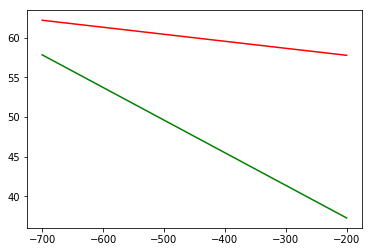

[2, 3] [4, 3]
2


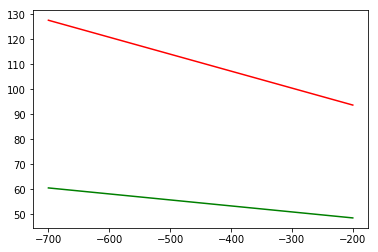

[0, 1] [3, 4]
0


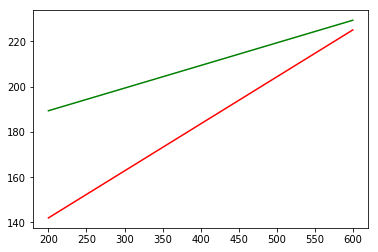

[2, 3] [4, 4]
2


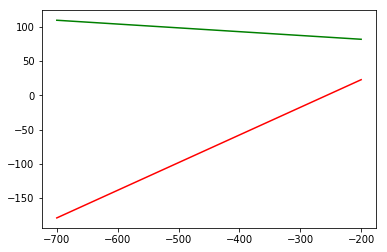

[2, 3] [4, 4]
2


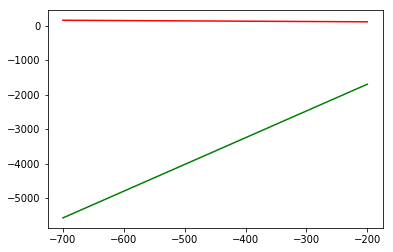

[2, 3] [4, 3]
2


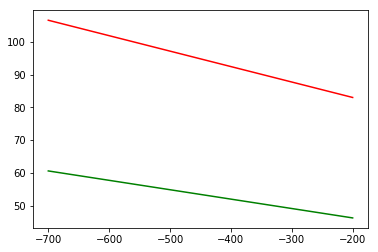

[2, 3] [3, 4]
2


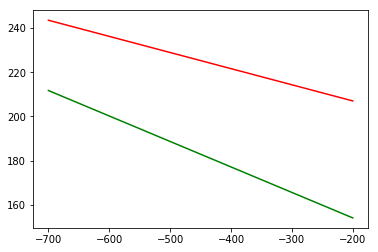

[2, 3] [3, 4]
2


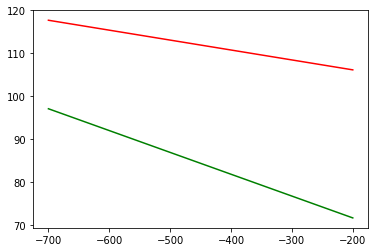

[2, 3] [3, 3]
2


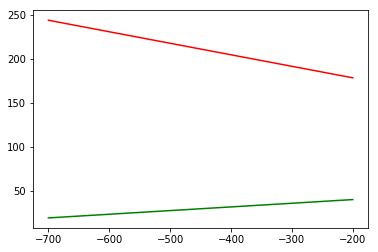

[2, 3] [4, 4]
2


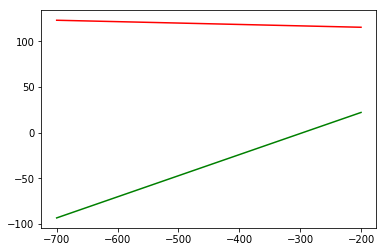

[0, 1] [4, 4]
0


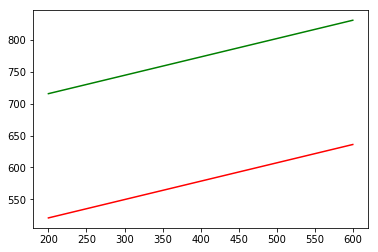

[2, 3] [4, 4]
2


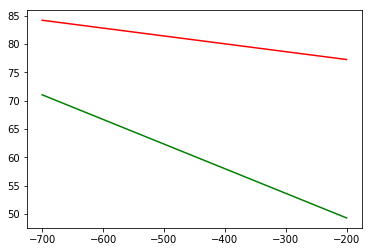

[2, 3] [4, 4]
2


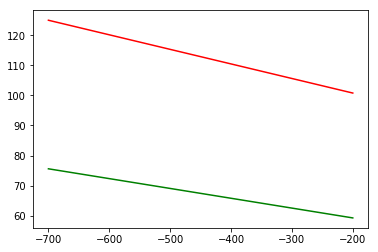

[2, 3] [4, 3]
2


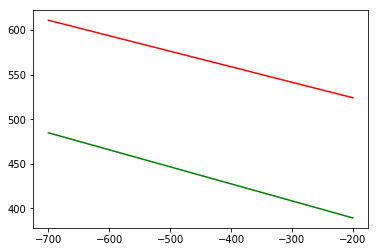

[2, 3] [3, 4]
2


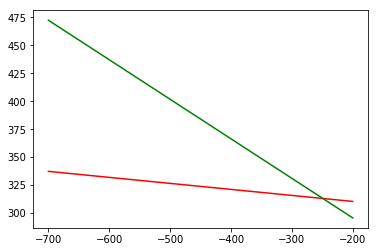

[2, 3] [4, 3]
2


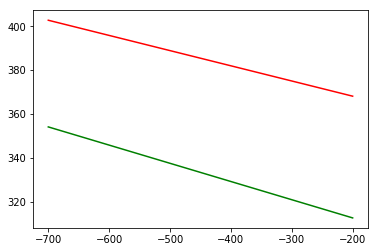

[2, 3] [4, 4]
2


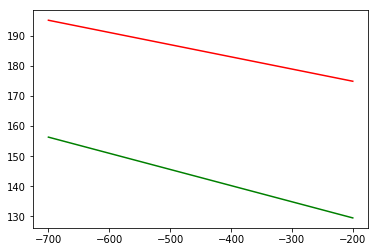

[2, 3] [4, 4]
2


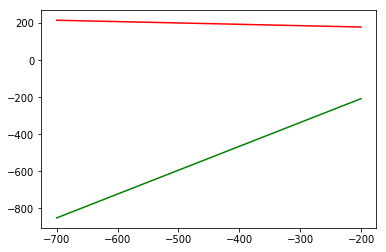

[2, 3] [4, 4]
2


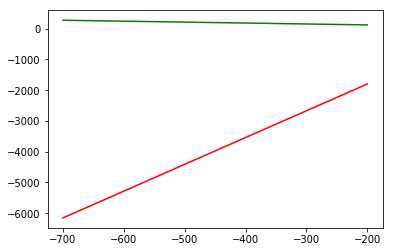

[2, 3] [4, 3]
2


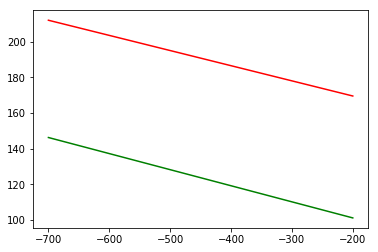

[2, 3] [4, 3]
2


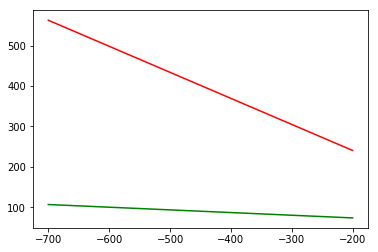

[2, 3] [4, 4]
2


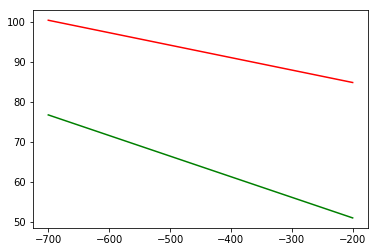

[2, 3] [4, 4]
2


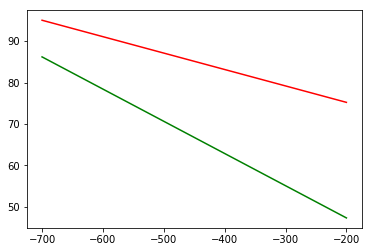

[2, 3] [4, 4]
2


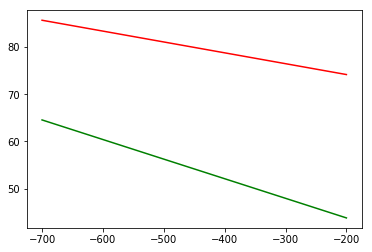

[2, 3] [3, 4]
2


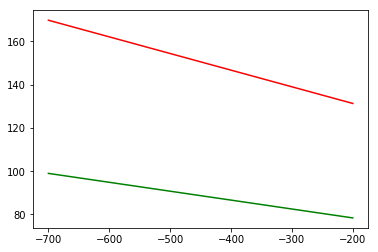

[2, 3] [4, 4]
2


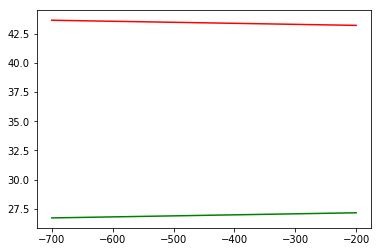

[2, 3] [4, 4]
2


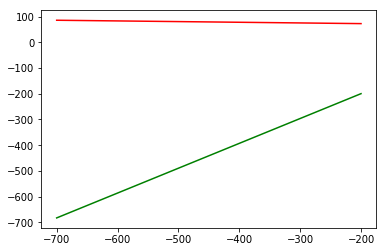

[2, 3] [4, 3]
2


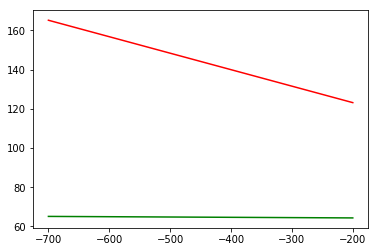

[2, 3] [4, 3]
2


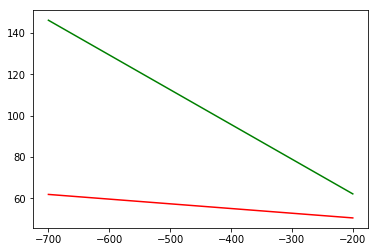

[2, 3] [4, 4]
2


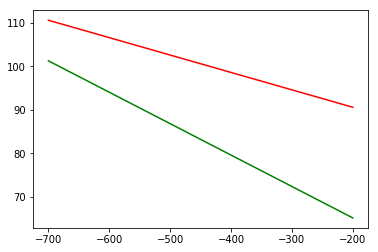

[2, 3] [4, 4]
2


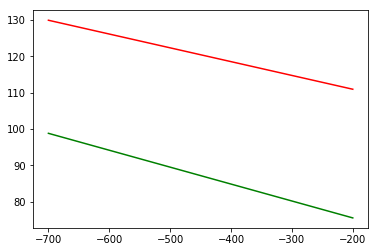

[2, 3] [3, 3]
2


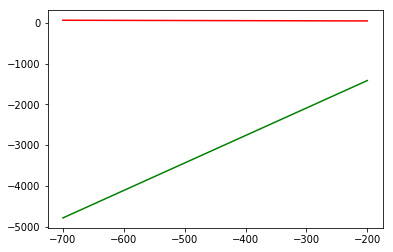

[2, 3] [4, 4]
2


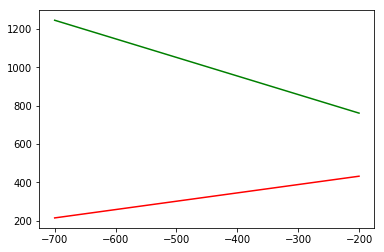

[2, 3] [3, 4]
2


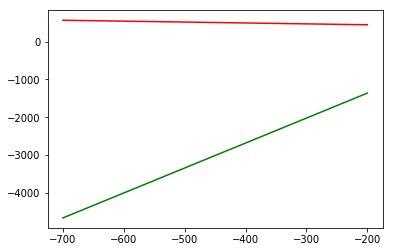

[2, 3] [4, 4]
2


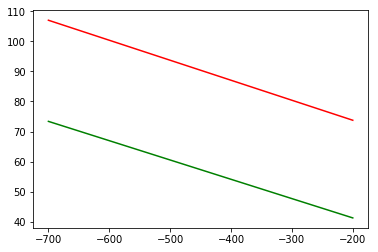

[2, 3] [3, 4]
2


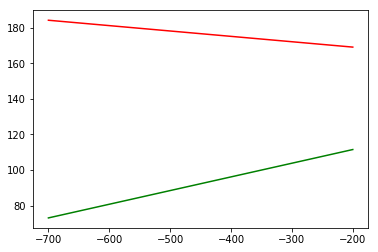

[2, 3] [4, 4]
2


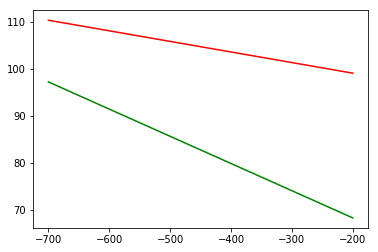

[2, 3] [4, 4]
2


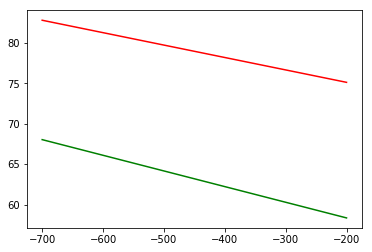

[2, 3] [4, 4]
2


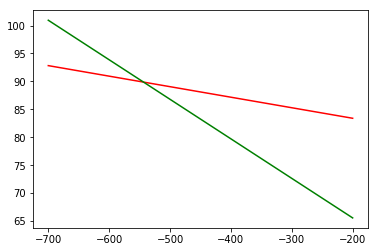

[2, 3] [4, 4]
2


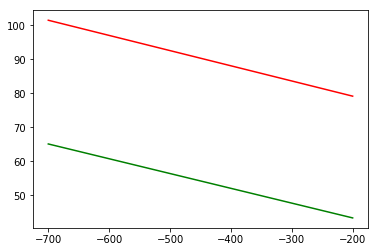

[2, 3] [4, 4]
2


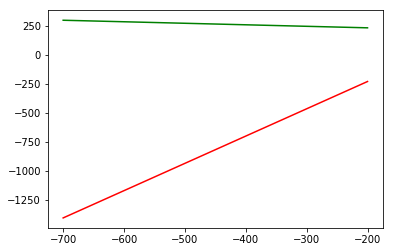

[2, 3] [4, 4]
2


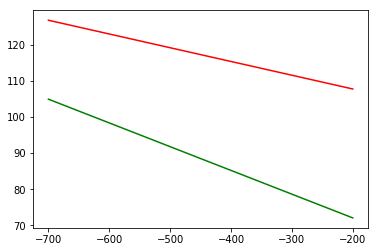

[0, 1] [3, 4]
0


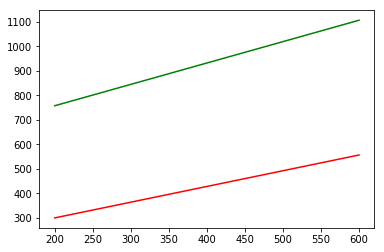

[2, 3] [4, 4]
2


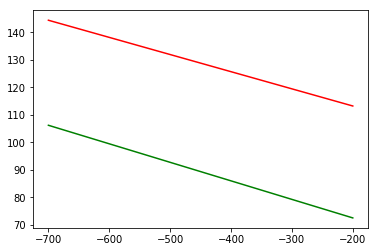

[2, 3] [4, 4]
2


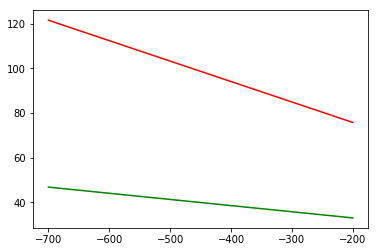

[2, 3] [3, 3]
2


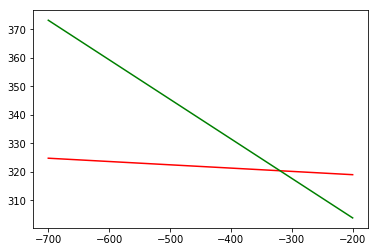

[2, 3] [4, 4]
2


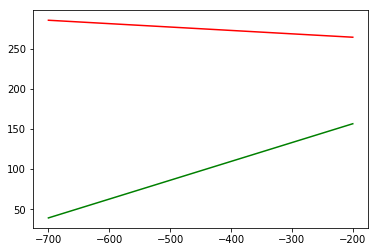

[2, 3] [4, 4]
2


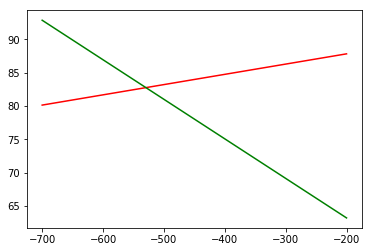

[2, 3] [4, 4]
2


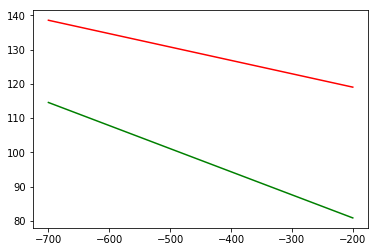

[2, 3] [4, 4]
2


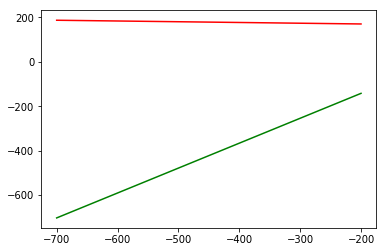

[2, 3] [4, 3]
2


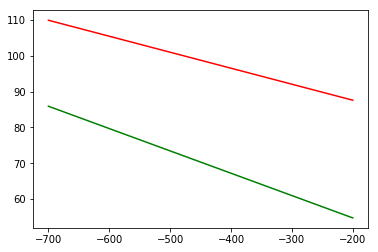

[2, 3] [4, 4]
2


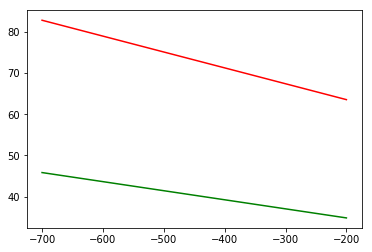

[2, 3] [4, 4]
2


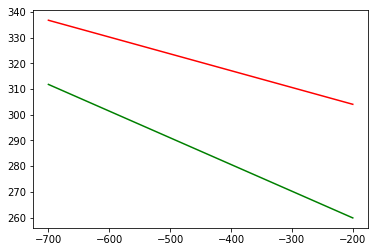

[2, 3] [4, 4]
2


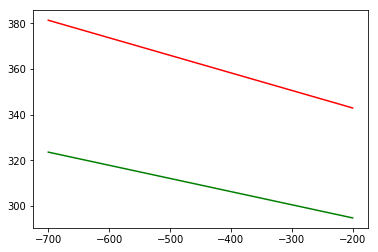

[2, 3] [3, 4]
2


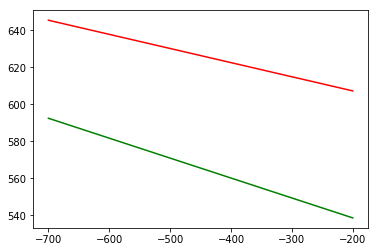

[2, 3] [4, 4]
2


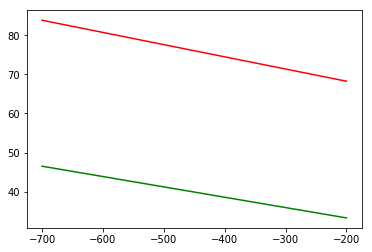

[2, 3] [4, 4]
2


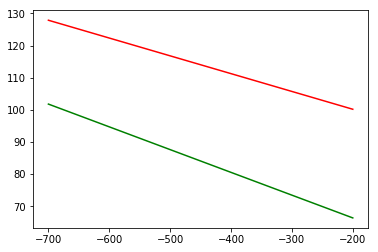

[0, 1] [4, 3]
0


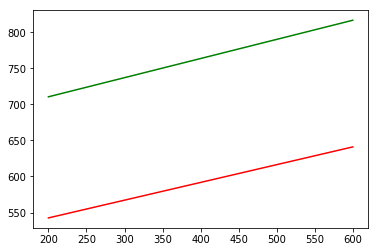

[2, 3] [3, 4]
2


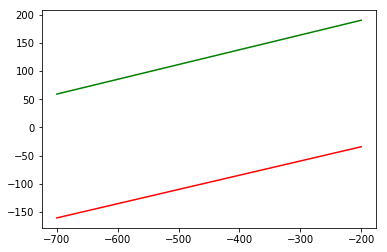

[2, 3] [3, 4]
2


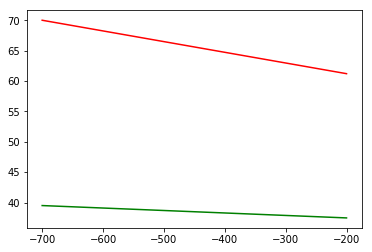

[2, 3] [4, 4]
2


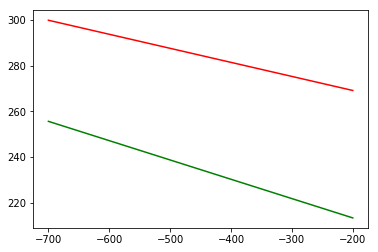

[2, 3] [4, 3]
2


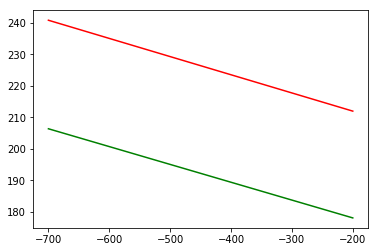

[2, 3] [4, 4]
2


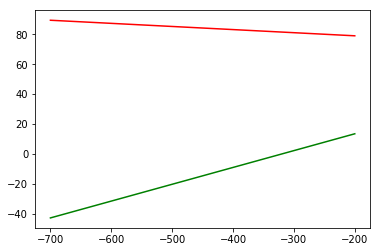

[2, 3] [4, 4]
2


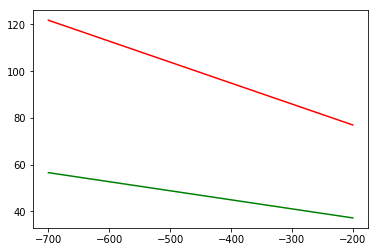

[2, 3] [4, 4]
2


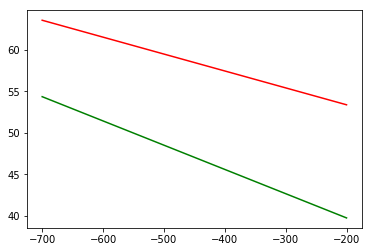

[2, 3] [4, 4]
2


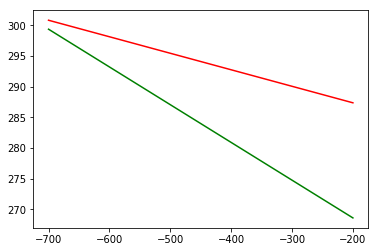

[2, 3] [4, 4]
2


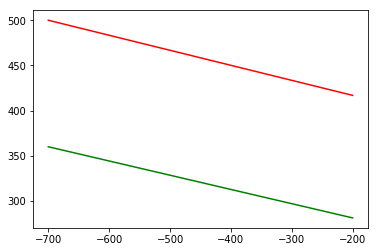

[2, 3] [4, 4]
2


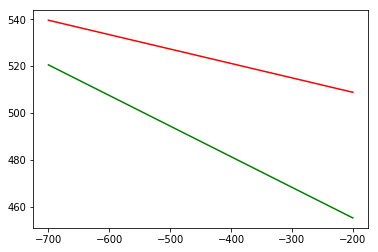

[2, 3] [4, 4]
2


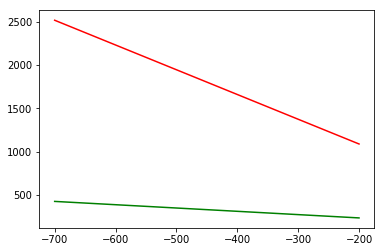

[2, 3] [3, 4]
2


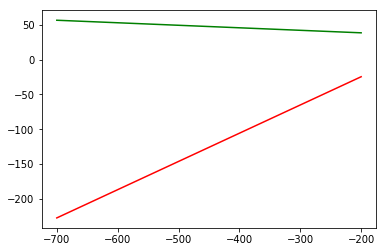

[2, 3] [4, 4]
2


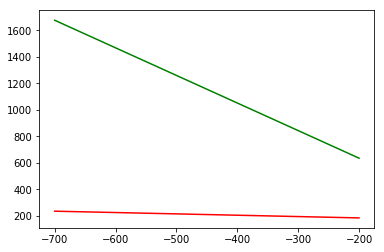

[2, 3] [4, 4]
2


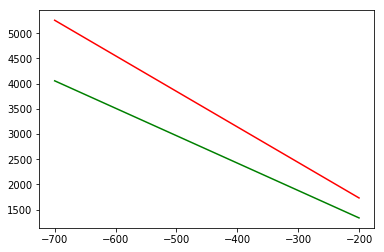

[2, 3] [4, 3]
2


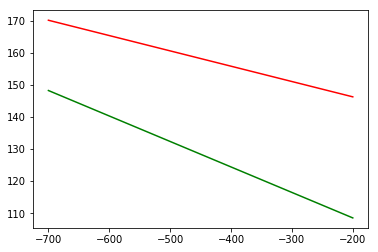

[2, 3] [4, 4]
2


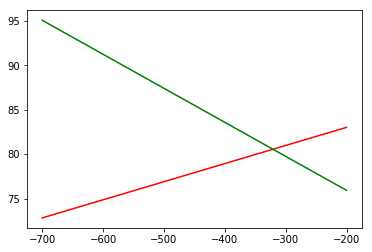

[2, 3] [4, 4]
2


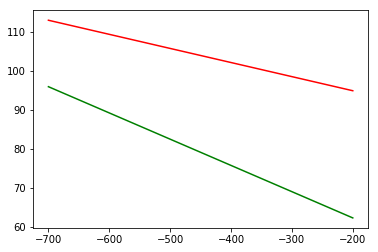

[2, 3] [4, 3]
2


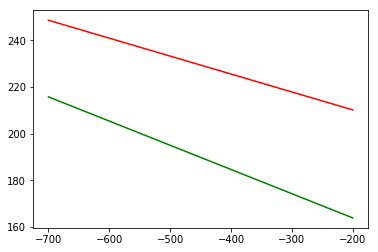

[0, 1] [4, 4]
0


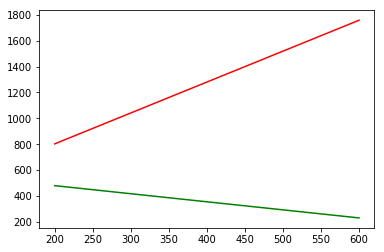

[2, 3] [3, 4]
2


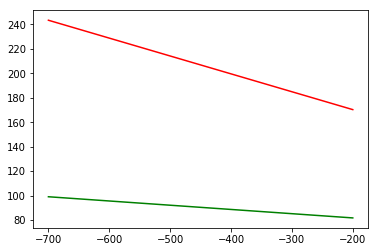

[2, 3] [4, 4]
2


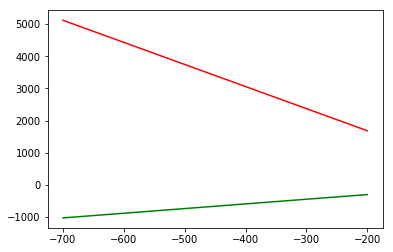

[2, 3] [4, 3]
2


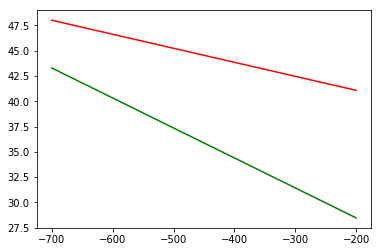

[2, 3] [4, 4]
2


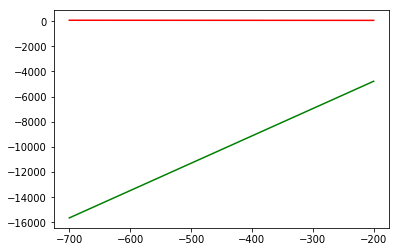

[2, 3] [4, 4]
2


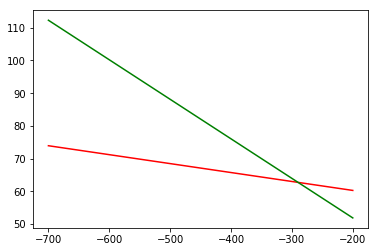

[2, 3] [4, 4]
2


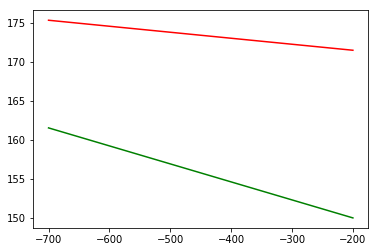

[2, 3] [4, 4]
2


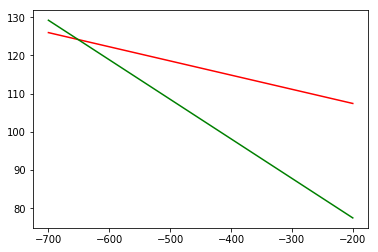

[2, 3] [3, 4]
2


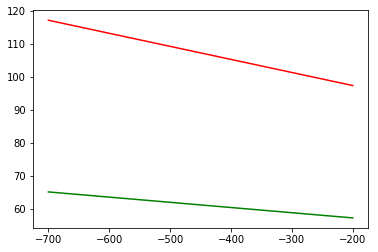

[2, 3] [3, 3]
2


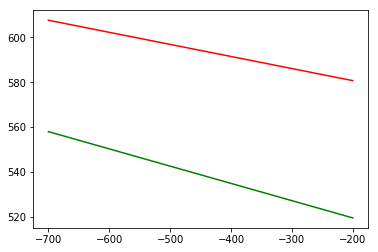

[0, 1] [4, 4]
0


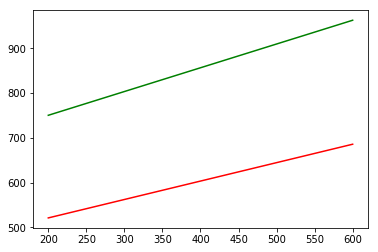

[2, 3] [4, 4]
2


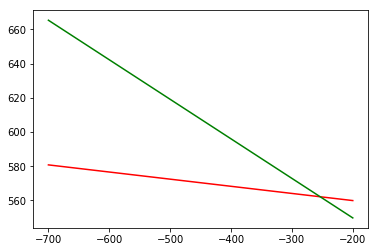

[2, 3] [3, 4]
2


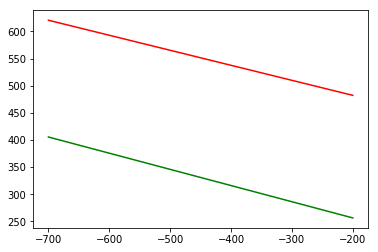

[2, 3] [3, 4]
2


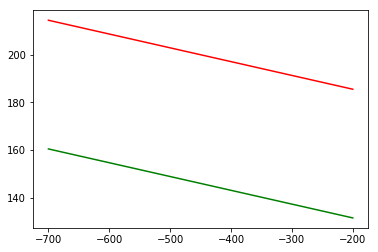

[2, 3] [4, 4]
2


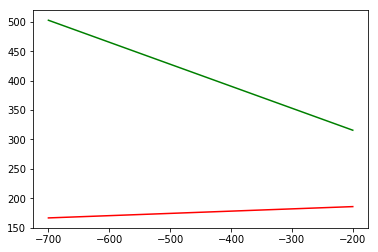

[2, 3] [4, 4]
2


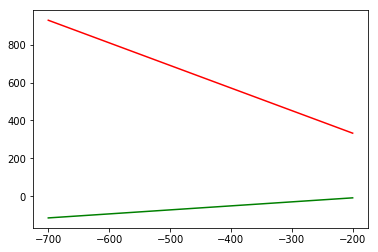

[2, 3] [4, 4]
2


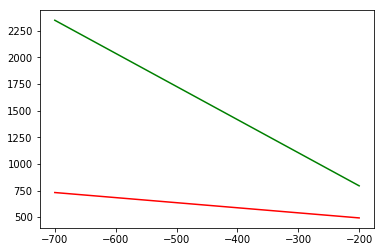

[2, 3] [4, 4]
2


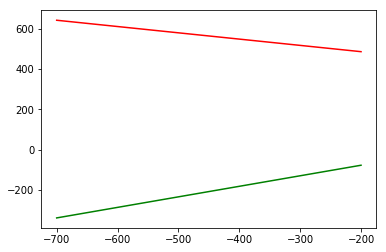

[0, 1] [4, 4]
0


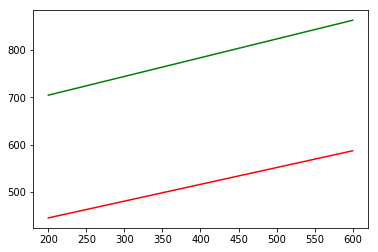

[2, 3] [4, 3]
2


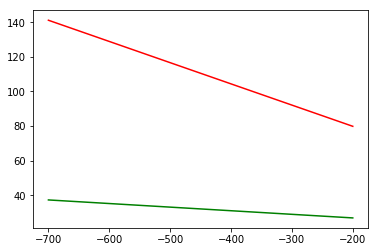

[2, 3] [4, 3]
2


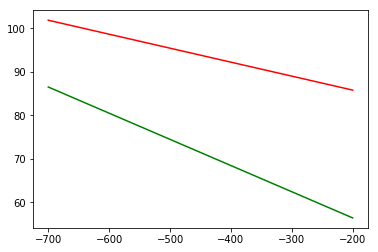

[2, 3] [4, 4]
2


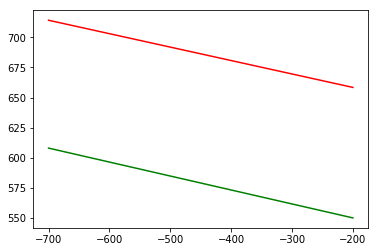

[2, 3] [4, 3]
2


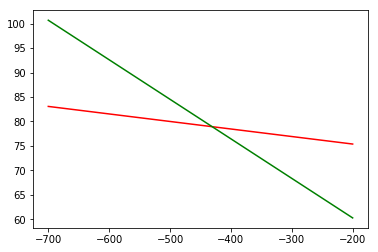

[2, 3] [4, 4]
2


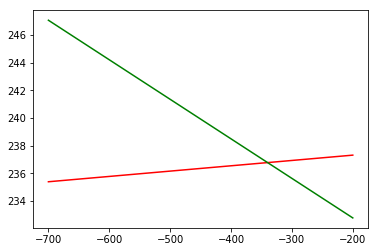

[2, 3] [4, 4]
2


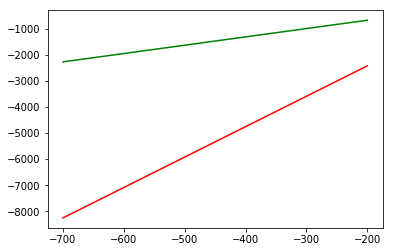

[2, 3] [4, 4]
2


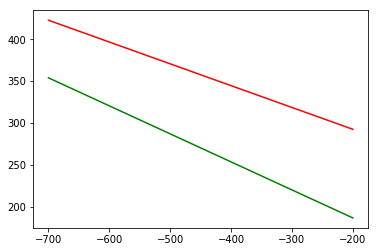

[2, 3] [4, 4]
2


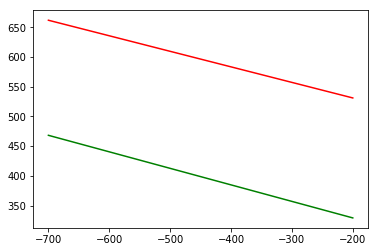

[2, 3] [4, 4]
2


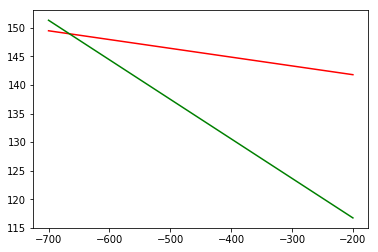

[2, 3] [4, 3]
2


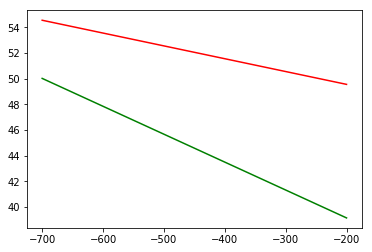

[2, 3] [4, 4]
2


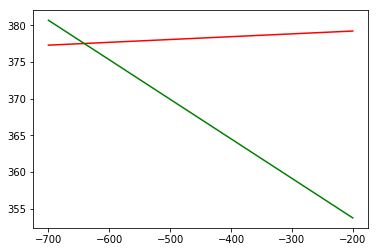

[2, 3] [4, 4]
2


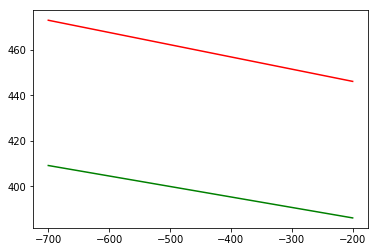

[2, 3] [4, 4]
2


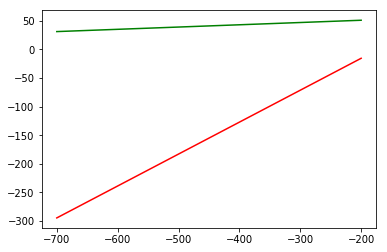

[2, 3] [4, 4]
2


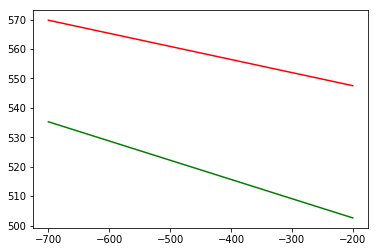

[0, 1] [4, 4]
0


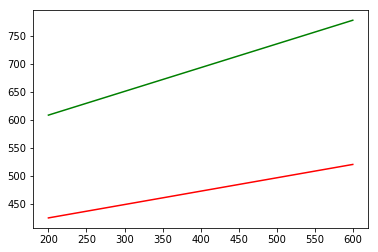

[2, 3] [4, 3]
2


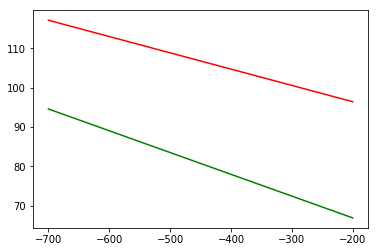

[2, 3] [4, 4]
2


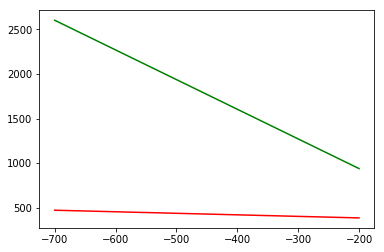

[2, 3] [4, 4]
2


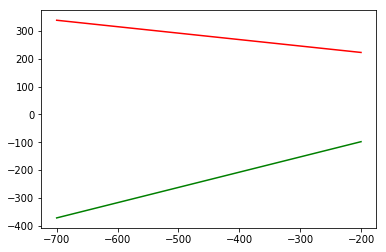

[2, 3] [4, 4]
2


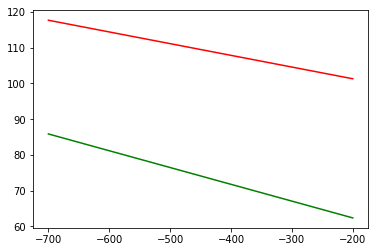

[2, 3] [4, 4]
2


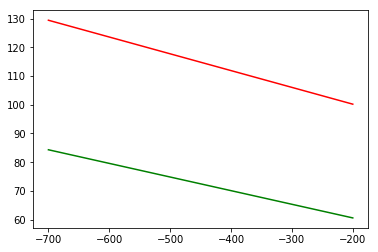

[2, 3] [4, 4]
2


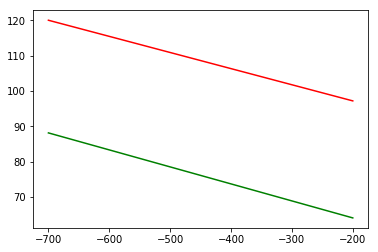

[2, 3] [4, 3]
2


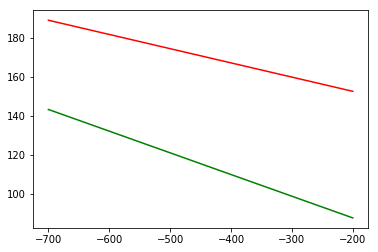

[2, 3] [3, 4]
2


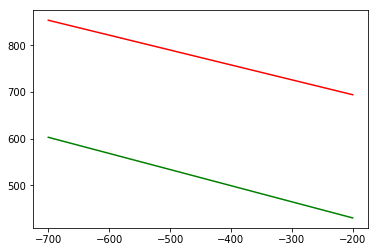

[2, 3] [4, 4]
2


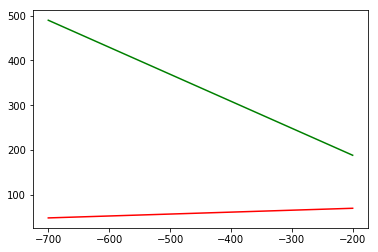

[2, 3] [4, 3]
2


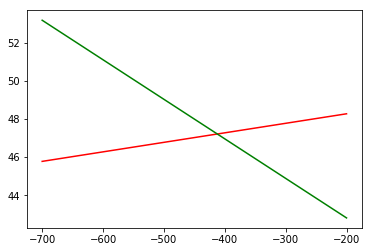

[2, 3] [4, 4]
2


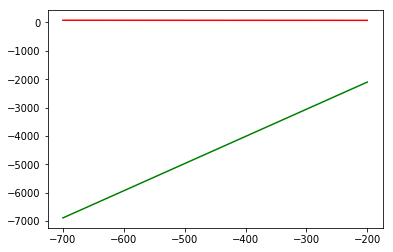

[2, 3] [4, 4]
2


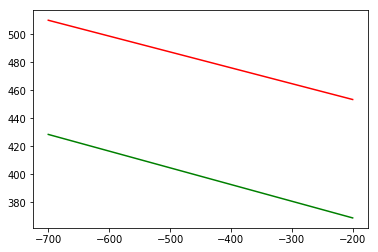

[2, 3] [4, 4]
2


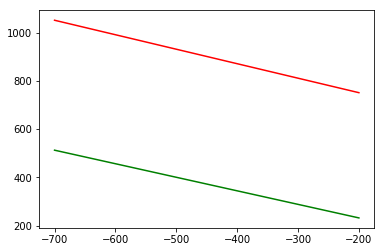

[2, 3] [4, 4]
2


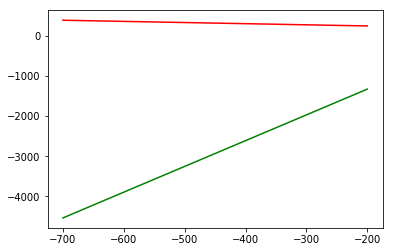

[2, 3] [4, 4]
2


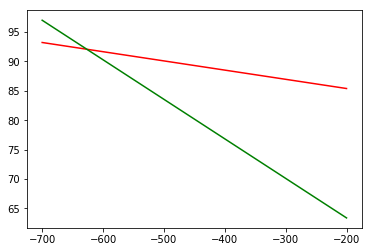

[2, 3] [3, 4]
2


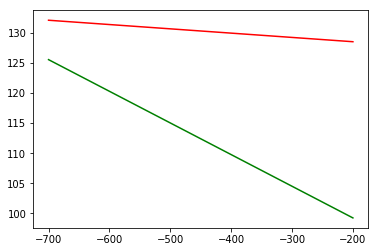

[2, 3] [4, 4]
2


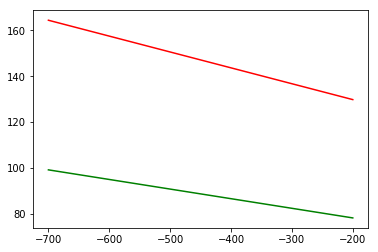

[2, 3] [4, 4]
2


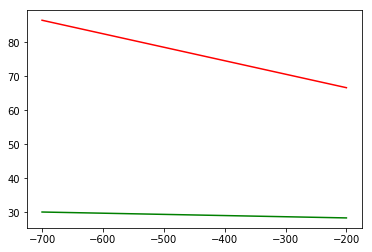

[2, 3] [4, 4]
2


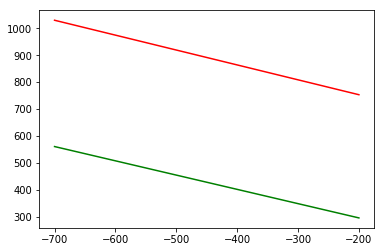

[2, 3] [4, 4]
2


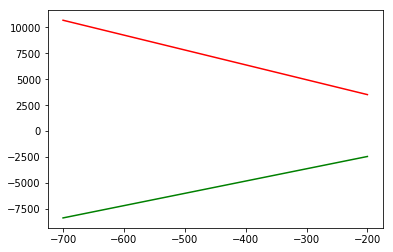

[2, 3] [4, 4]
2


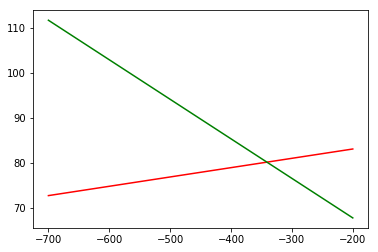

[2, 3] [4, 4]
2


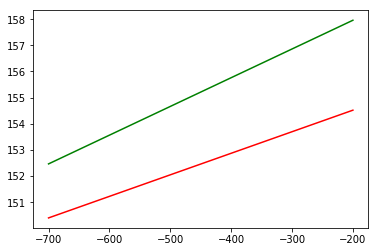

[2, 3] [4, 3]
2


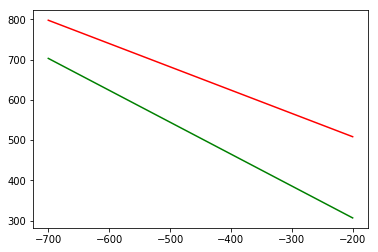

[2, 3] [4, 4]
2


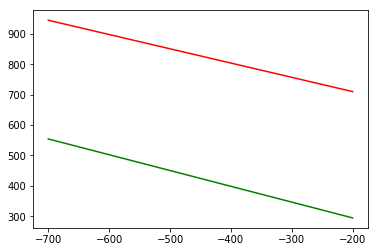

[2, 3] [4, 4]
2


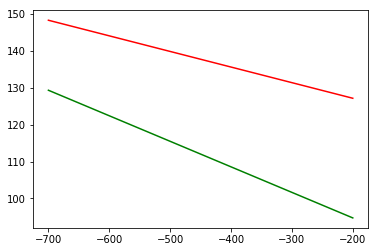

[2, 3] [3, 4]
2


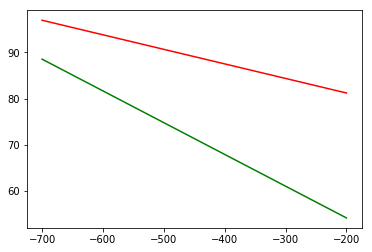

[2, 3] [4, 4]
2


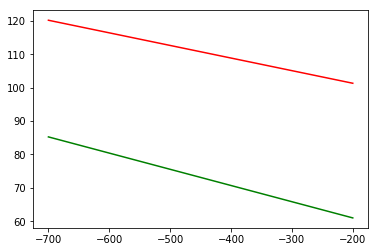

[2, 3] [4, 4]
2


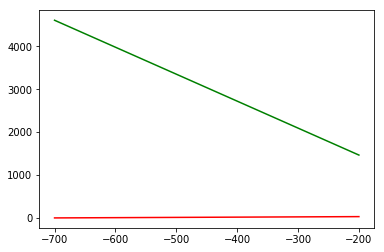

[2, 3] [4, 4]
2


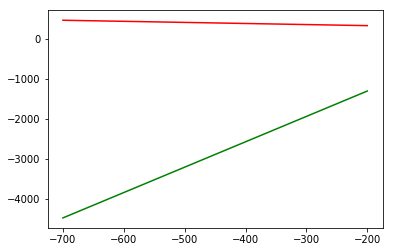

[2, 3] [4, 4]
2


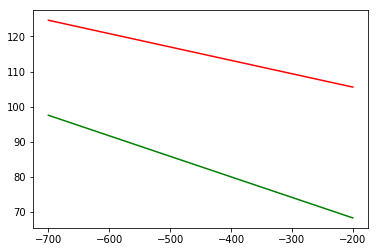

[0, 1] [4, 3]
0


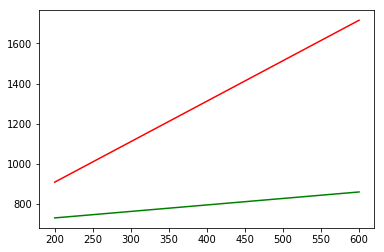

[2, 3] [4, 4]
2


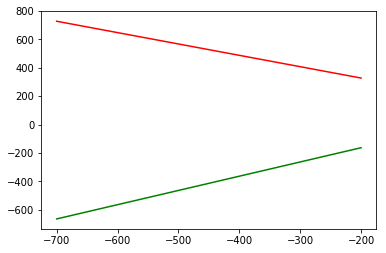

[2, 3] [4, 4]
2


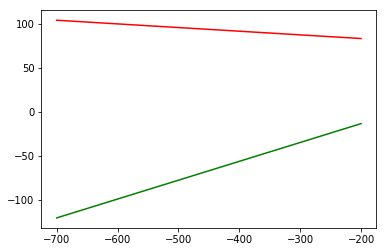

[2, 3] [3, 4]
2


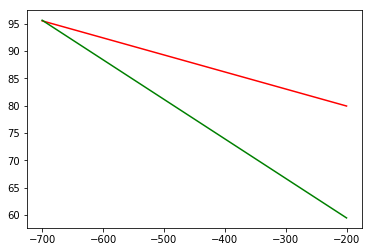

[2, 3] [3, 4]
2


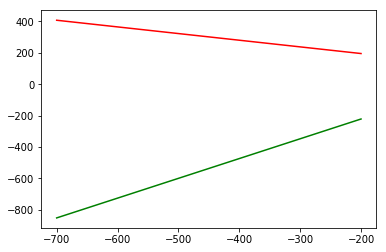

[2, 3] [4, 4]
2


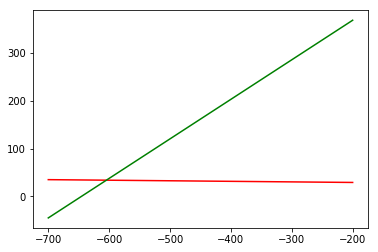

[2, 3] [4, 4]
2


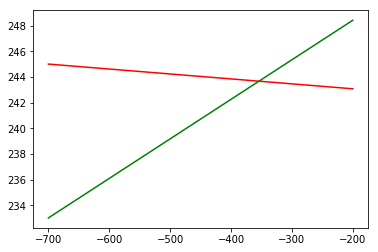

[2, 3] [4, 3]
2


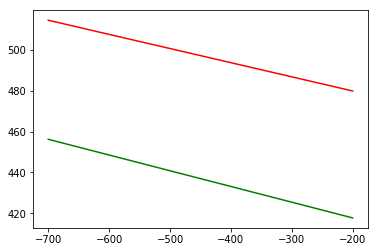

[2, 3] [4, 4]
2


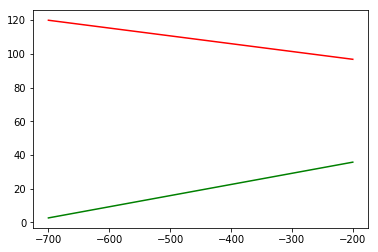

[0, 1] [3, 4]
0


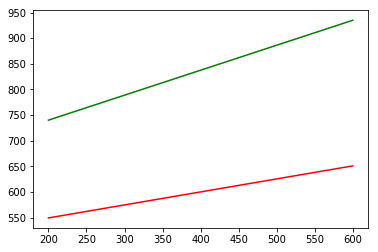

[2, 3] [4, 4]
2


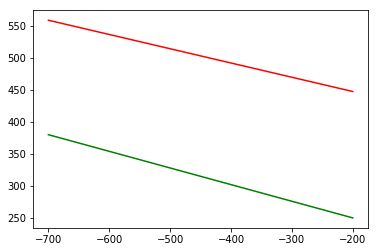

[2, 3] [4, 4]
2


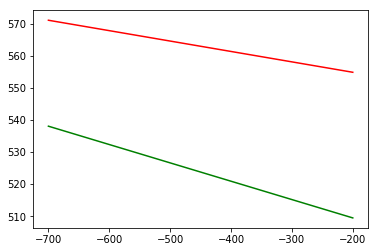

[2, 3] [4, 3]
2


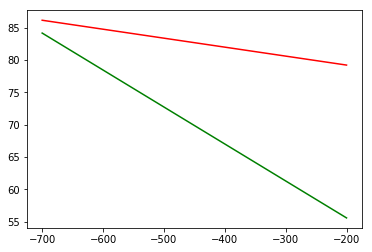

[2, 3] [3, 4]
2


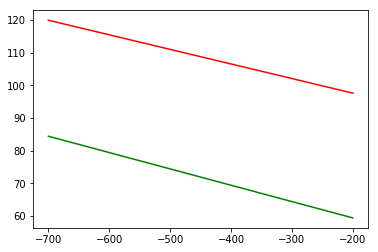

[2, 3] [4, 4]
2


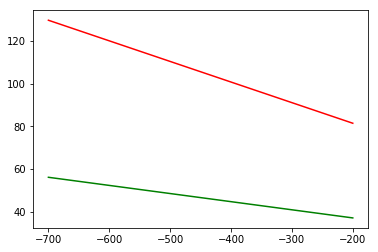

[2, 3] [3, 4]
2


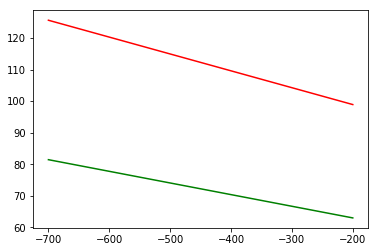

[2, 3] [4, 4]
2


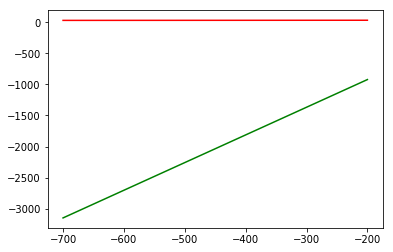

[2, 3] [3, 4]
2


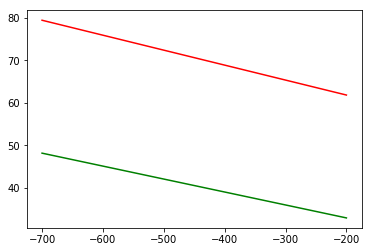

[2, 3] [4, 4]
2


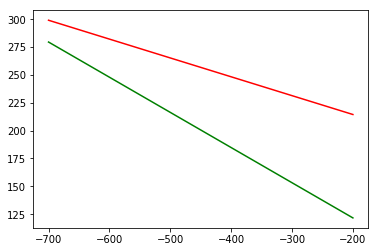

[2, 3] [4, 4]
2


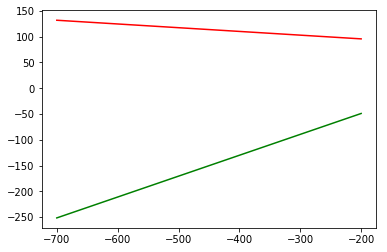

[2, 3] [4, 4]
2


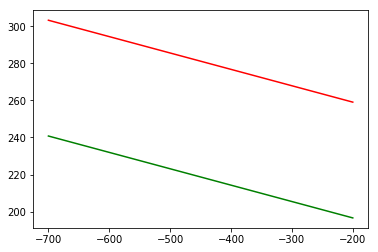

[2, 3] [4, 4]
2


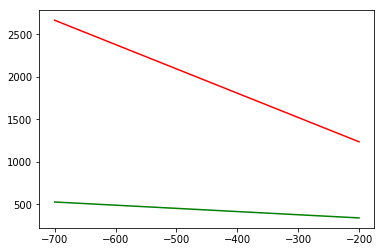

[2, 3] [4, 4]
2


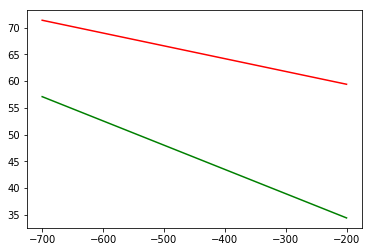

[2, 3] [4, 4]
2


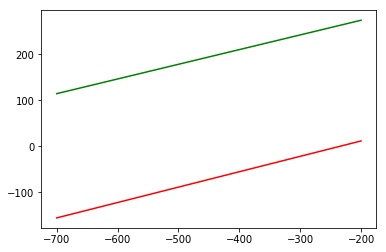

[0, 1] [3, 4]
0


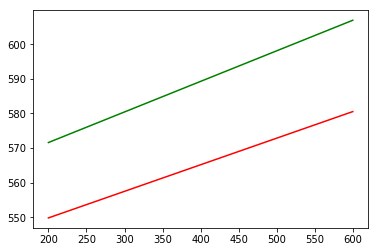

[2, 3] [4, 4]
2


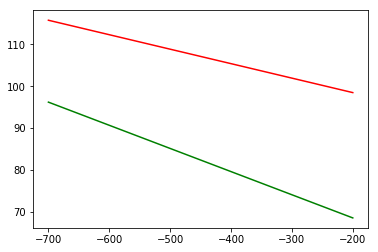

[2, 3] [4, 4]
2


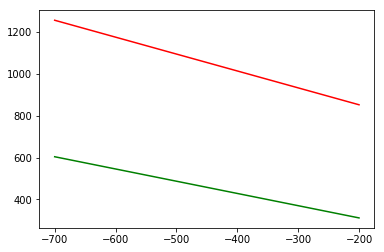

[2, 3] [4, 4]
2


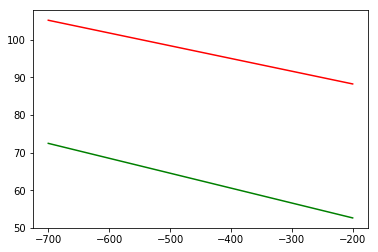

[2, 3] [4, 3]
2


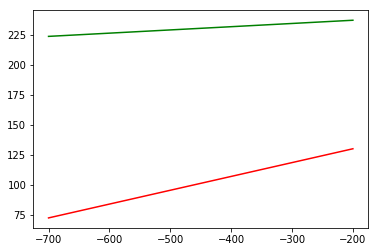

[2, 3] [4, 4]
2


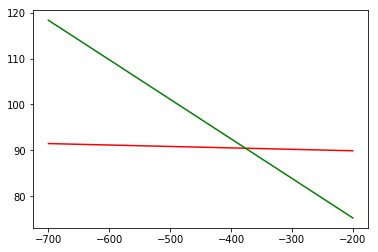

[2, 3] [4, 4]
2


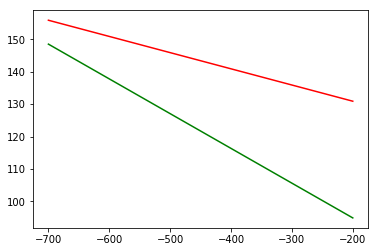

[2, 3] [4, 4]
2


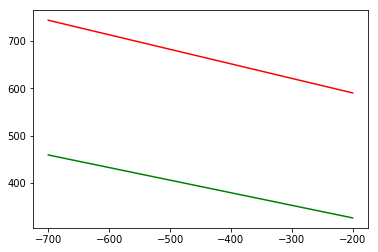

[2, 3] [4, 4]
2


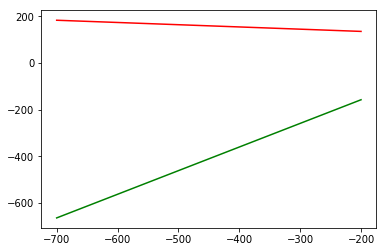

[2, 3] [4, 4]
2


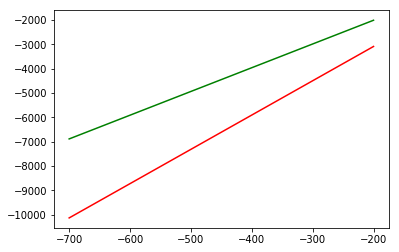

[2, 3] [4, 4]
2


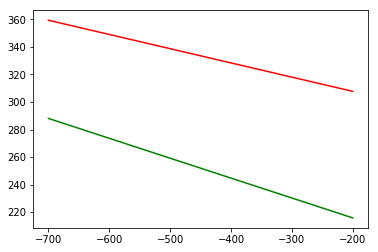

[2, 3] [4, 4]
2


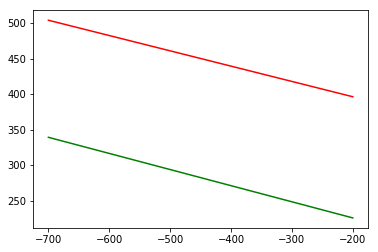

[2, 3] [4, 4]
2


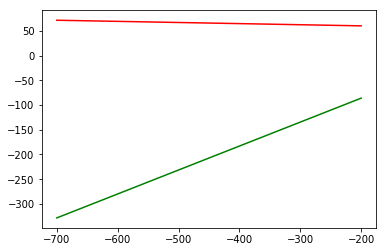

[2, 3] [4, 4]
2


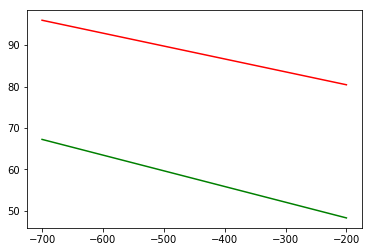

[2, 3] [3, 4]
2


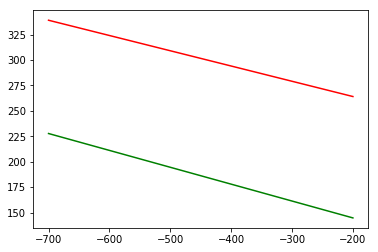

[2, 3] [4, 4]
2


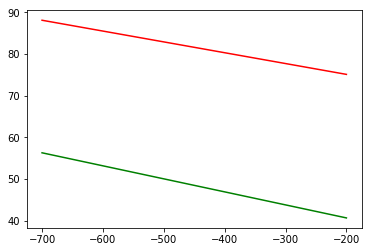

[2, 3] [4, 4]
2


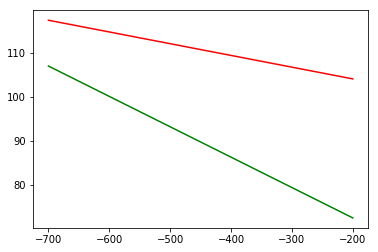

[2, 3] [4, 4]
2


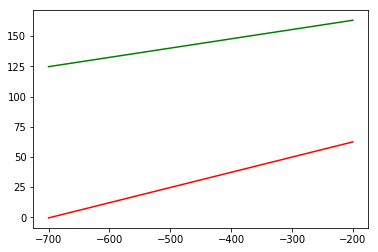

[2, 3] [4, 4]
2


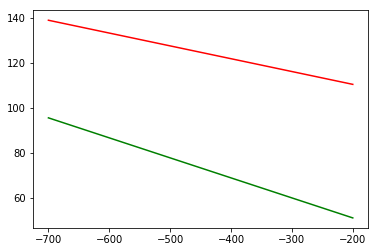

[2, 3] [4, 4]
2


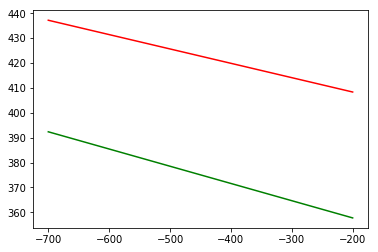

[2, 3] [3, 4]
2


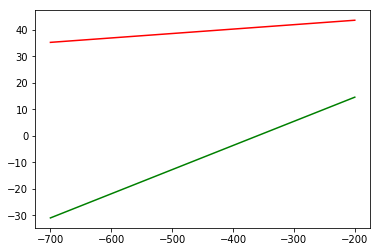

[2, 3] [4, 4]
2


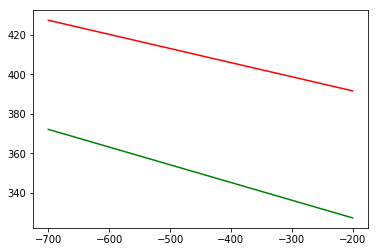

[2, 3] [4, 3]
2


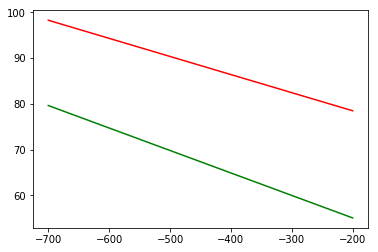

[2, 3] [4, 4]
2


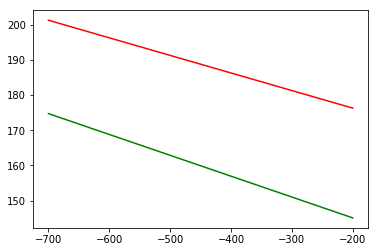

[2, 3] [4, 3]
2


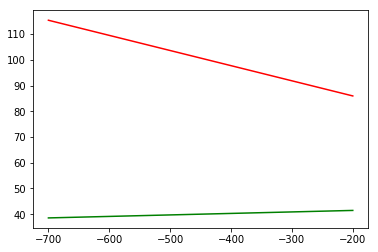

[2, 3] [3, 4]
2


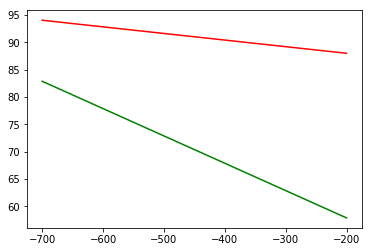

[2, 3] [3, 4]
2


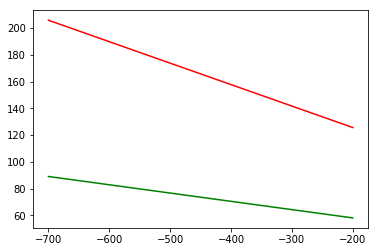

[2, 3] [4, 4]
2


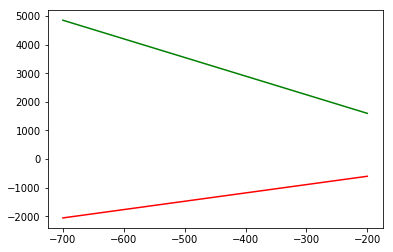

[2, 3] [4, 4]
2


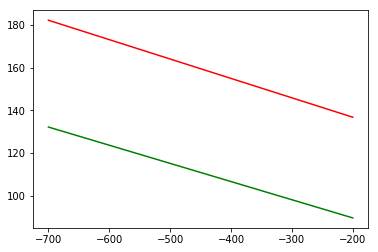

[2, 3] [4, 4]
2


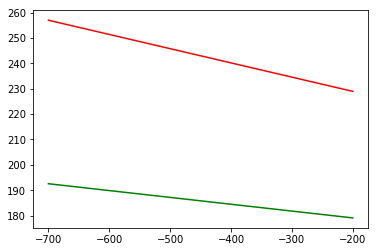

[2, 3] [4, 4]
2


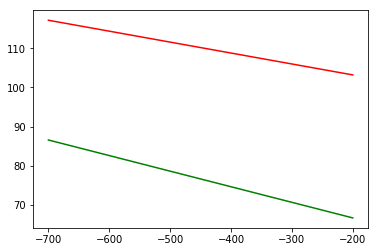

[2, 3] [4, 4]
2


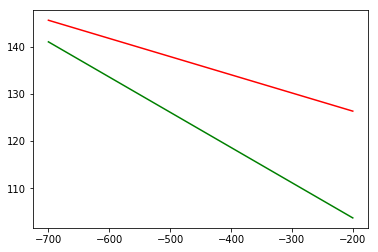

[2, 3] [4, 4]
2


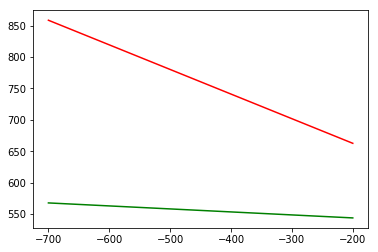

[2, 3] [4, 3]
2


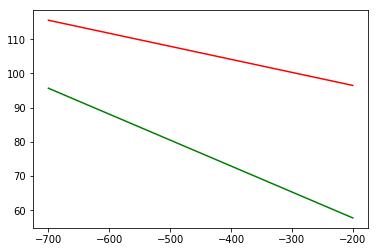

[2, 3] [4, 4]
2


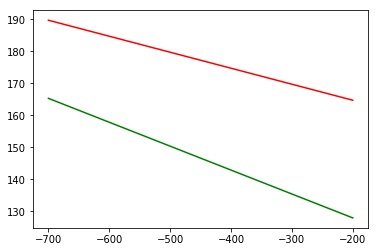

[2, 3] [4, 3]
2


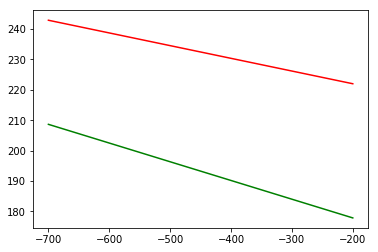

[0, 1] [3, 3]
0


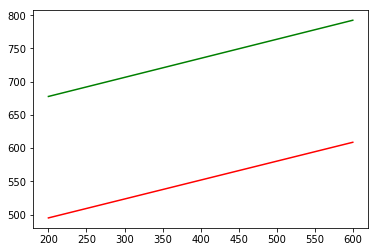

[2, 3] [4, 4]
2


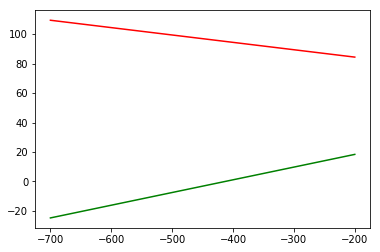

[0, 1] [3, 4]
0


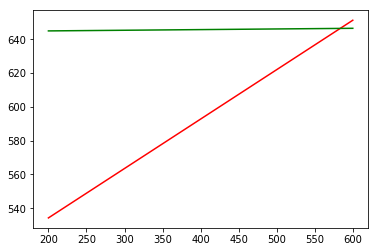

[2, 3] [4, 4]
2


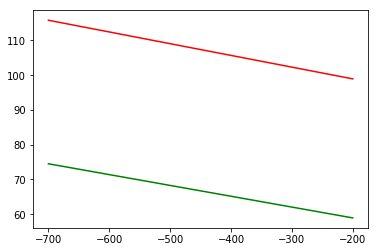

[2, 3] [4, 3]
2


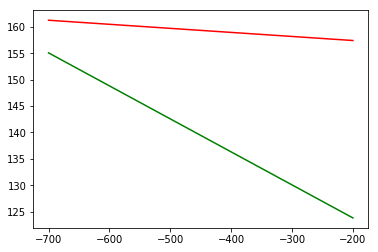

[2, 3] [4, 4]
2


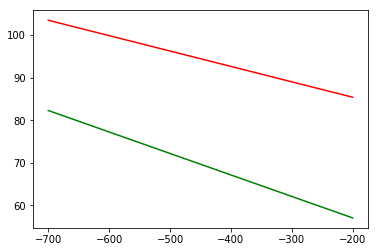

[2, 3] [4, 4]
2


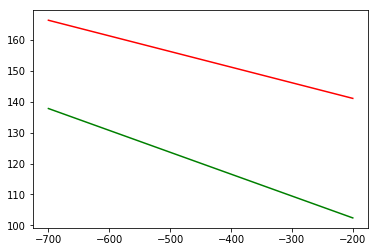

[2, 3] [4, 4]
2


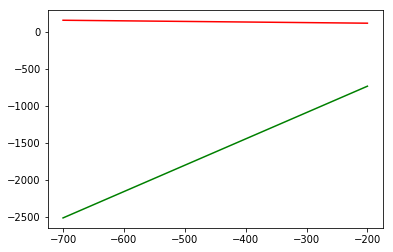

[2, 3] [4, 4]
2


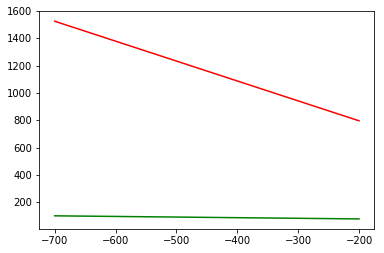

[2, 3] [4, 4]
2


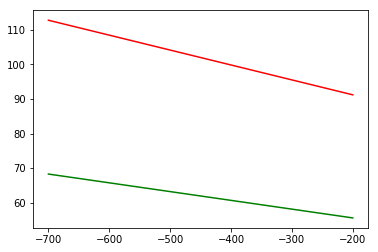

[2, 3] [4, 4]
2


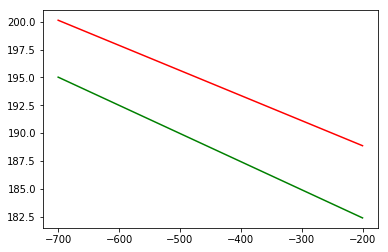

[2, 3] [4, 4]
2


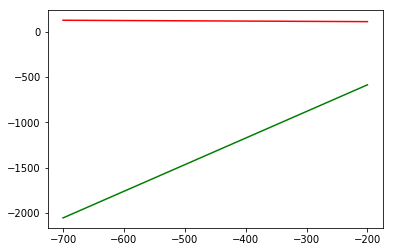

[2, 3] [4, 4]
2


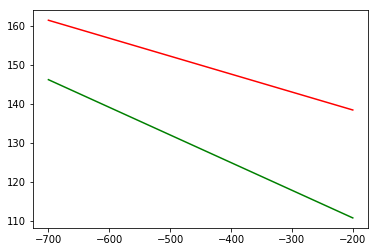

[2, 3] [4, 4]
2


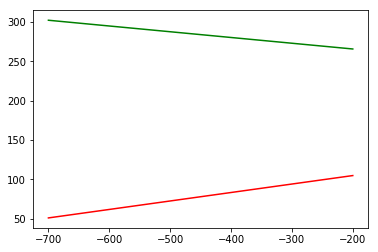

[2, 3] [3, 4]
2


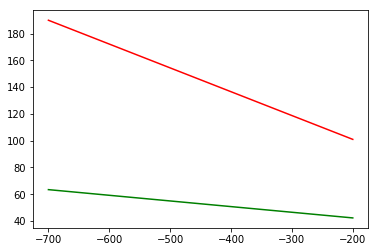

[2, 3] [3, 4]
2


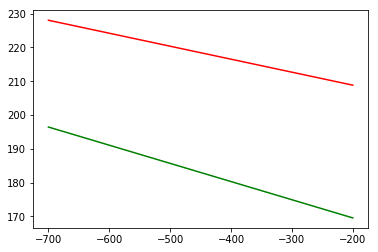

[2, 3] [3, 4]
2


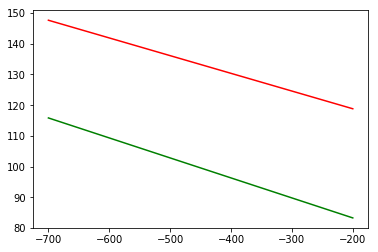

[2, 3] [3, 4]
2


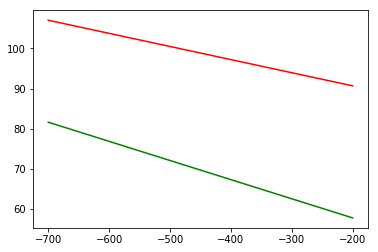

[2, 3] [4, 4]
2


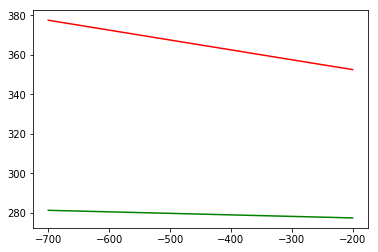

[2, 3] [4, 4]
2


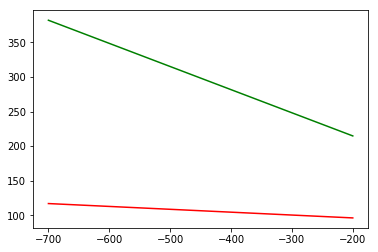

[2, 3] [3, 4]
2


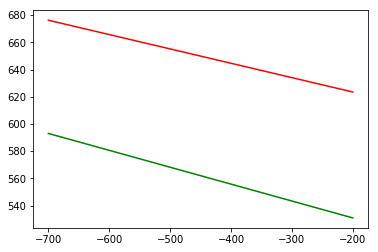

[2, 3] [4, 4]
2


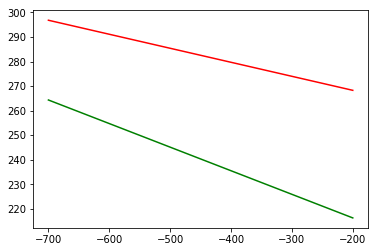

[2, 3] [3, 4]
2


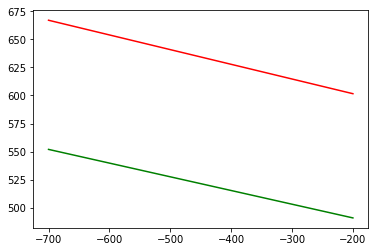

[2, 3] [3, 4]
2


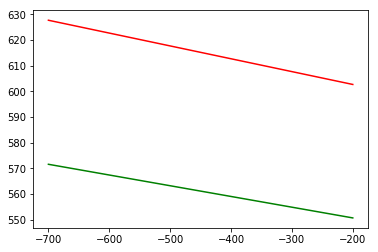

[2, 3] [4, 4]
2


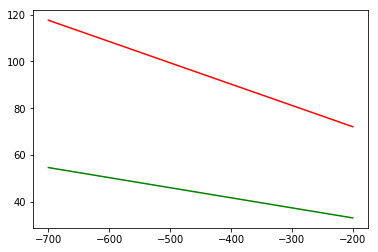

[2, 3] [4, 4]
2


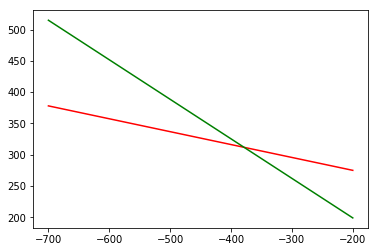

[2, 3] [4, 4]
2


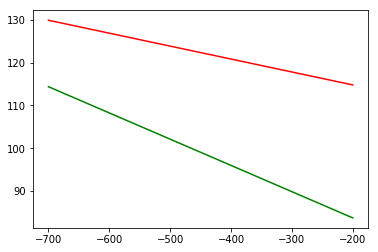

[2, 3] [4, 4]
2


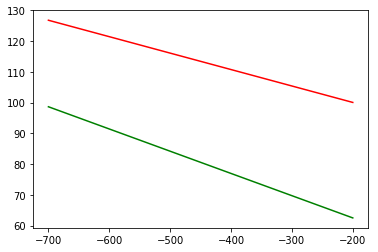

[2, 3] [3, 3]
2


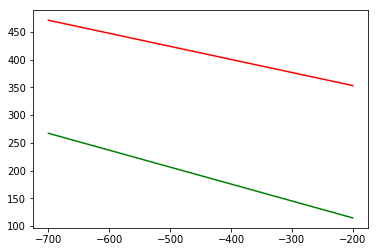

[2, 3] [4, 4]
2


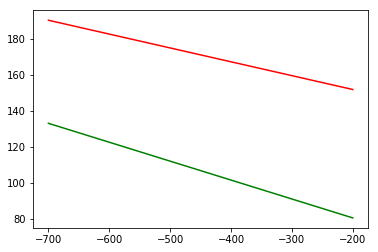

[0, 1] [3, 4]
0


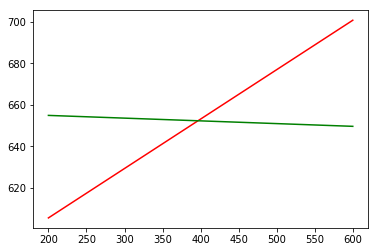

[2, 3] [4, 4]
2


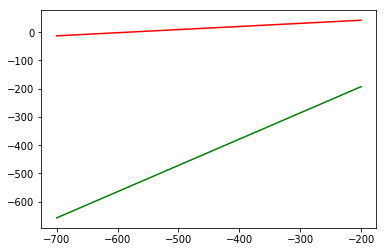

[2, 3] [4, 4]
2


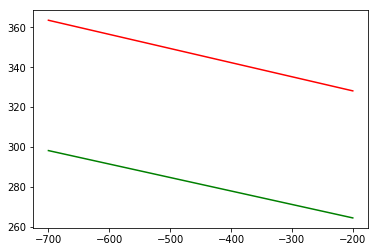

[2, 3] [4, 4]
2


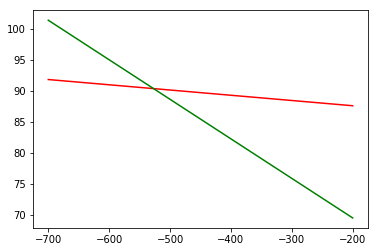

[2, 3] [4, 4]
2


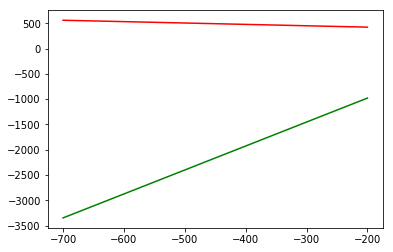

[2, 3] [3, 4]
2


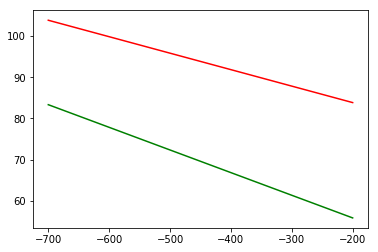

[2, 3] [4, 4]
2


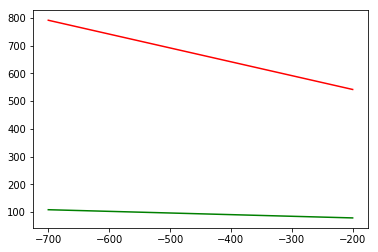

[2, 3] [4, 4]
2


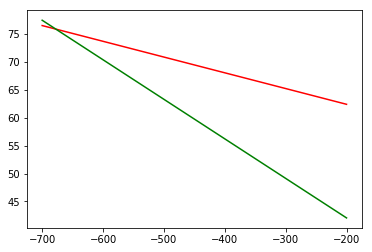

[2, 3] [3, 4]
2


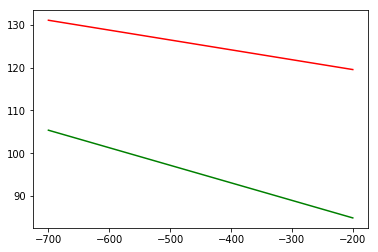

[2, 3] [4, 4]
2


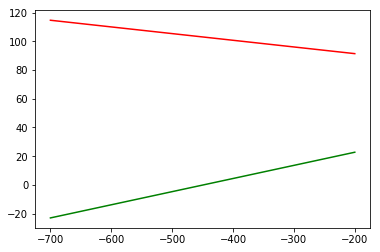

[2, 3] [3, 4]
2


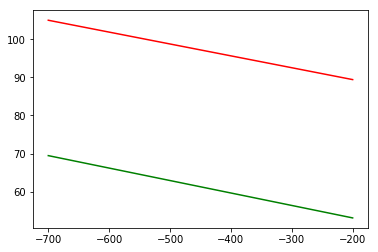

[2, 3] [4, 4]
2


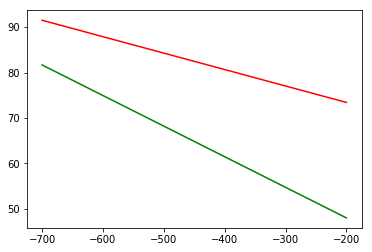

[2, 3] [4, 4]
2


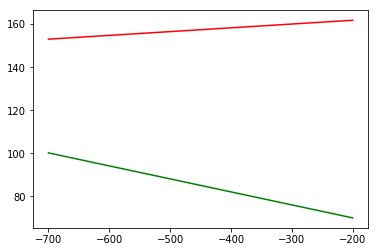

[2, 3] [4, 4]
2


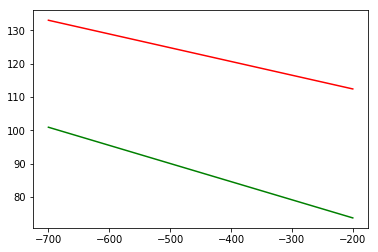

[2, 3] [4, 4]
2


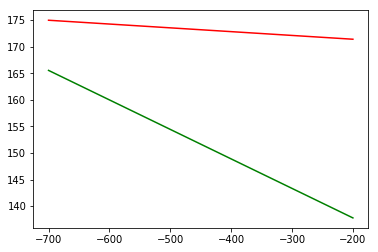

[2, 3] [4, 4]
2


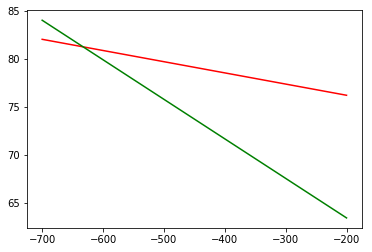

[2, 3] [4, 4]
2


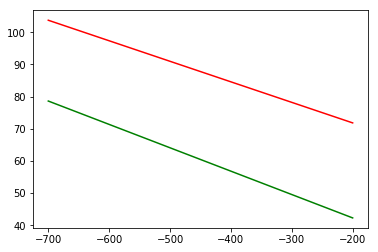

[2, 3] [3, 4]
2


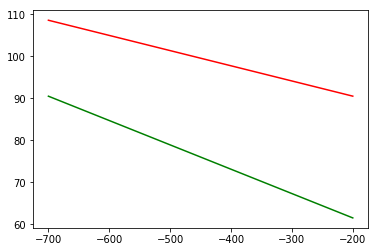

[2, 3] [4, 4]
2


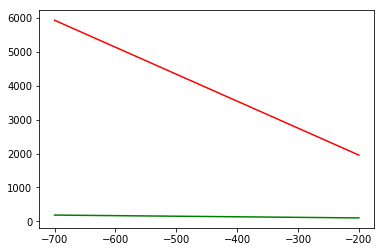

[2, 3] [4, 4]
2


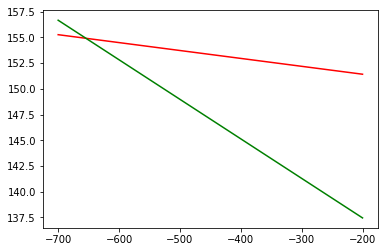

[2, 3] [4, 3]
2


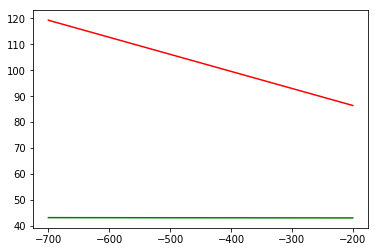

[2, 3] [4, 4]
2


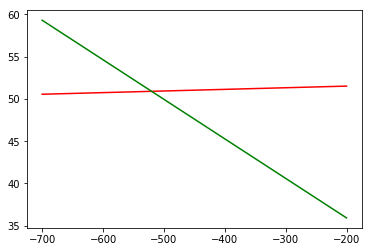

[2, 3] [4, 4]
2


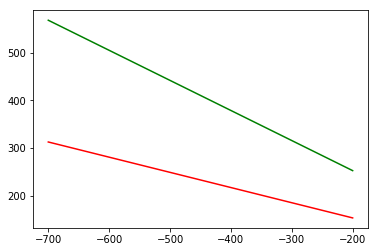

[2, 3] [4, 4]
2


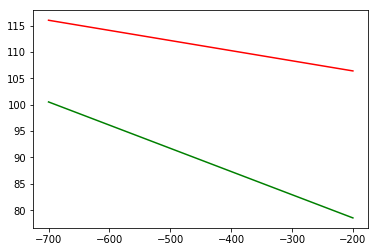

[2, 3] [3, 4]
2


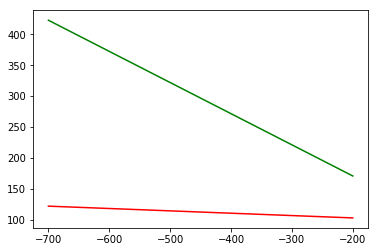

[2, 3] [4, 4]
2


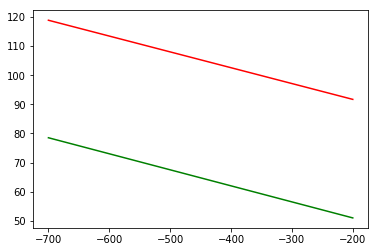

[2, 3] [4, 3]
2


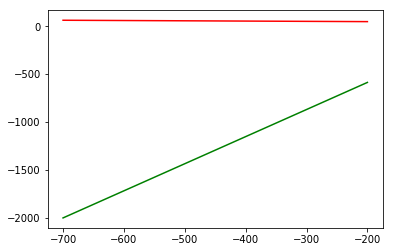

[2, 3] [4, 4]
2


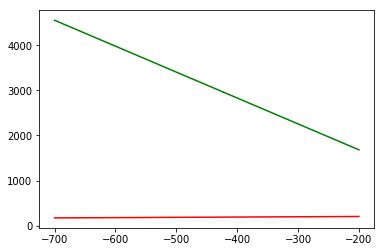

[2, 3] [4, 4]
2


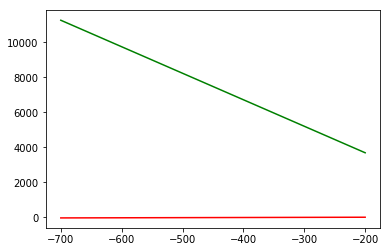

[2, 3] [4, 3]
2


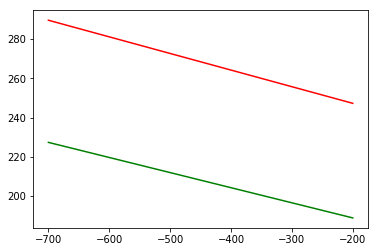

[2, 3] [3, 4]
2


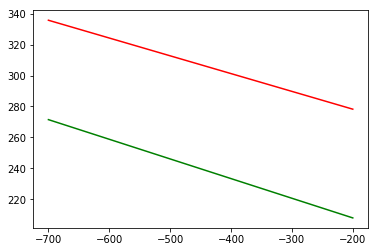

[2, 3] [4, 4]
2


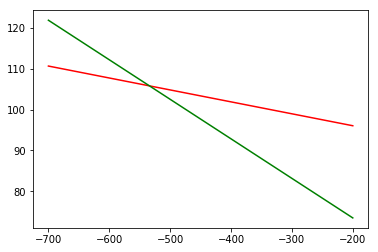

[2, 3] [3, 4]
2


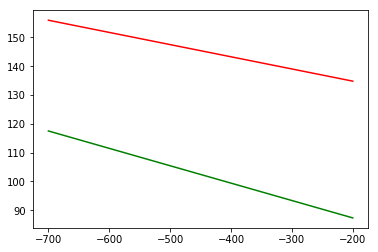

[2, 3] [4, 3]
2


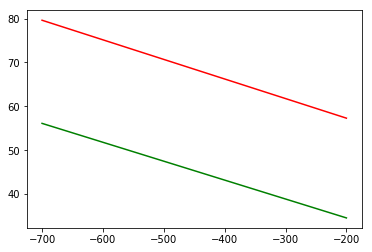

[2, 3] [3, 4]
2


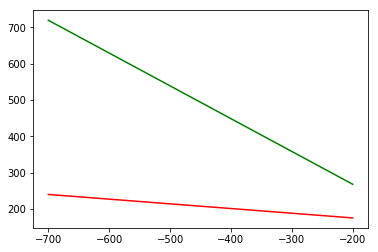

[0, 1] [4, 4]
0


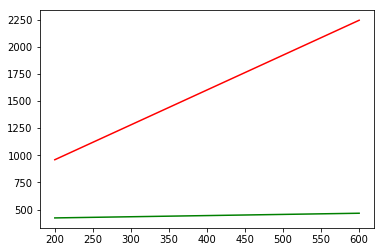

[0, 1] [3, 4]
0


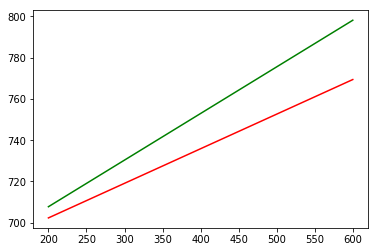

[2, 3] [4, 4]
2


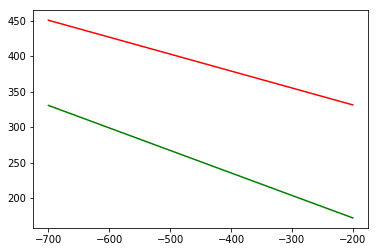

[2, 3] [4, 4]
2


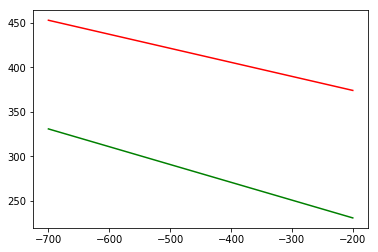

[2, 3] [4, 3]
2


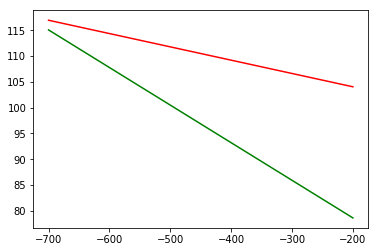

[2, 3] [4, 4]
2


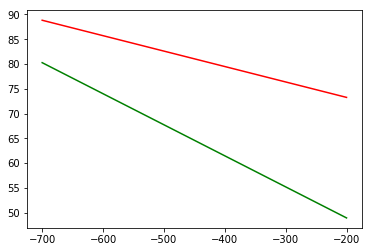

[2, 3] [3, 4]
2


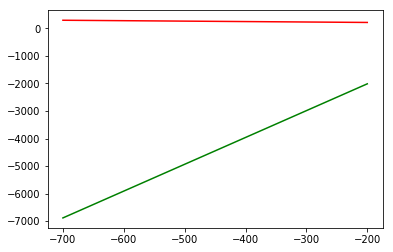

[2, 3] [3, 4]
2


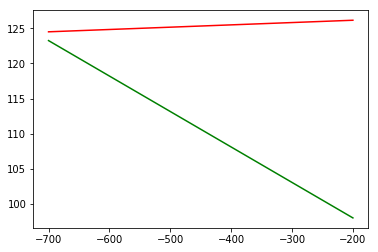

[2, 3] [4, 4]
2


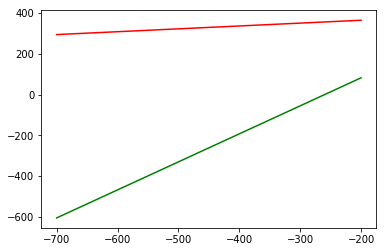

[2, 3] [4, 4]
2


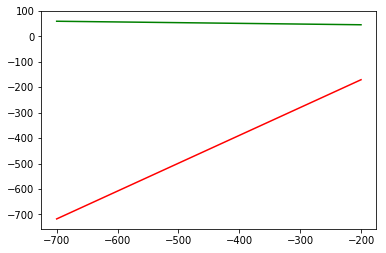

[2, 3] [4, 4]
2


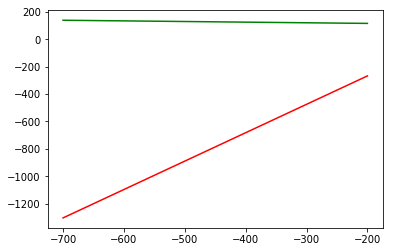

[2, 3] [4, 4]
2


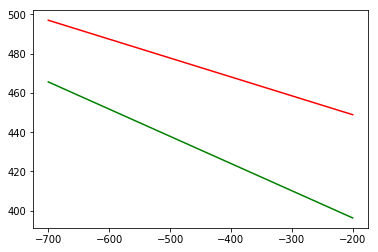

[2, 3] [4, 4]
2


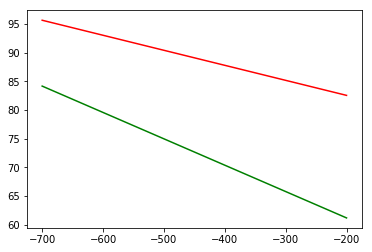

[2, 3] [4, 4]
2


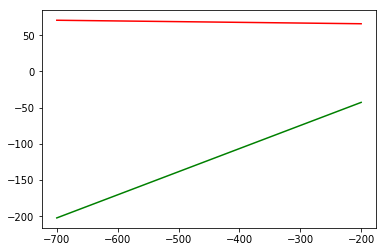

[2, 3] [3, 4]
2


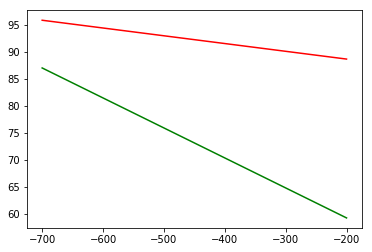

[2, 3] [4, 4]
2


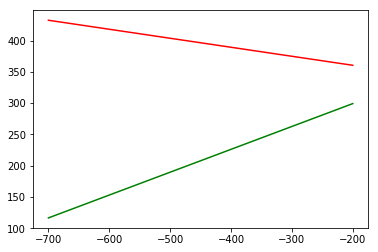

[2, 3] [4, 4]
2


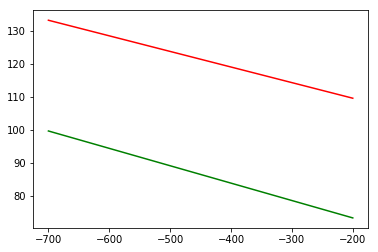

[2, 3] [4, 4]
2


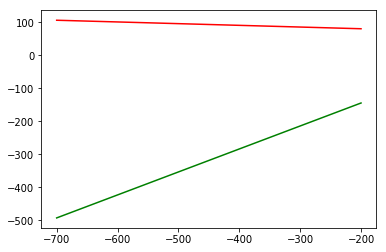

[2, 3] [4, 4]
2


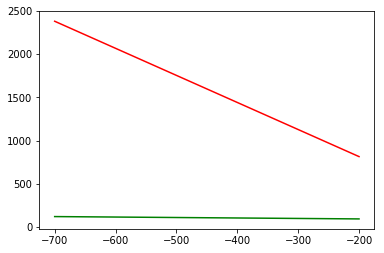

[2, 3] [4, 4]
2


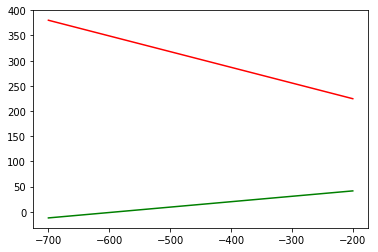

[2, 3] [4, 3]
2


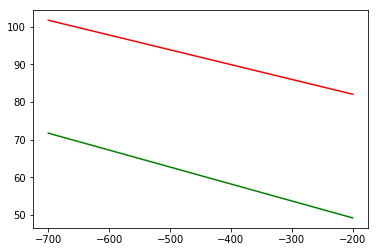

[2, 3] [4, 4]
2


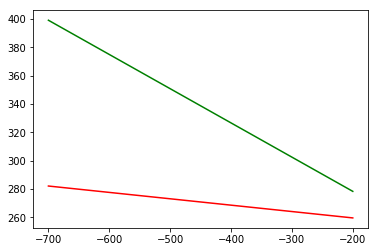

[2, 3] [4, 4]
2


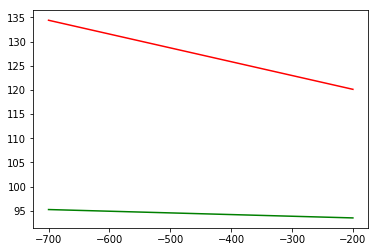

[2, 3] [4, 4]
2


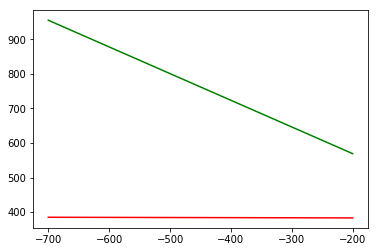

[2, 3] [4, 4]
2


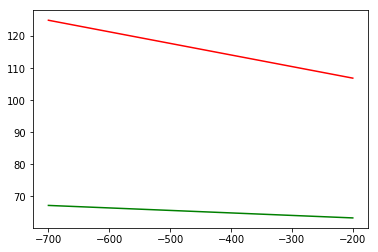

[2, 3] [4, 4]
2


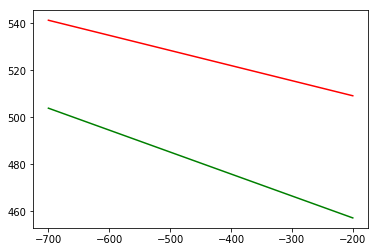

[2, 3] [4, 4]
2


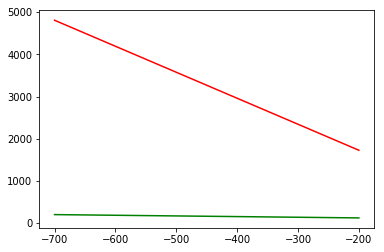

[2, 3] [4, 4]
2


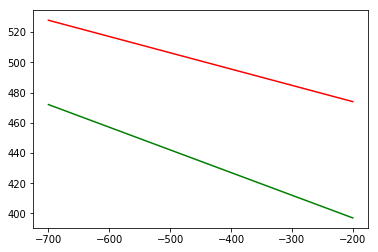

[2, 3] [4, 4]
2


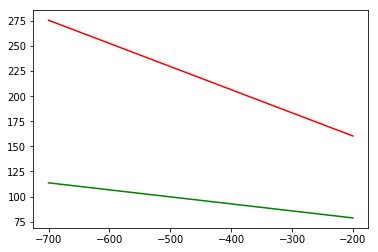

[2, 3] [4, 4]
2


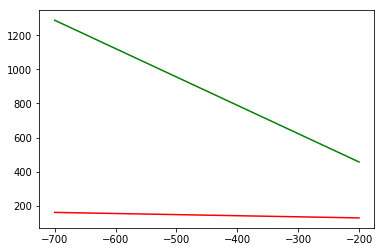

[2, 3] [4, 4]
2


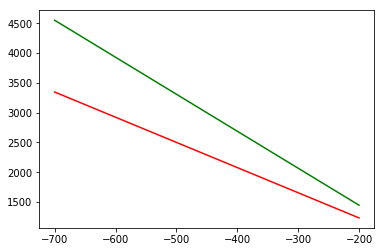

[2, 3] [4, 4]
2


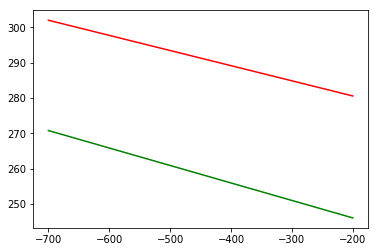

[2, 3] [4, 3]
2


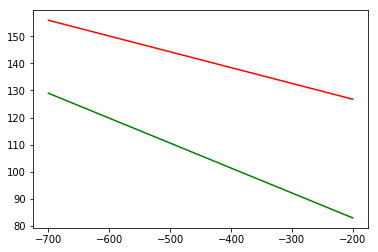

[2, 3] [4, 3]
2


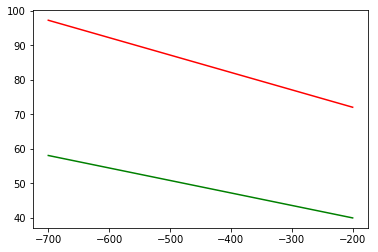

[2, 3] [3, 4]
2


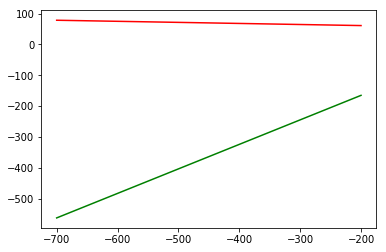

[2, 3] [4, 4]
2


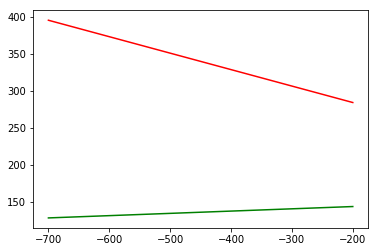

[2, 3] [3, 4]
2


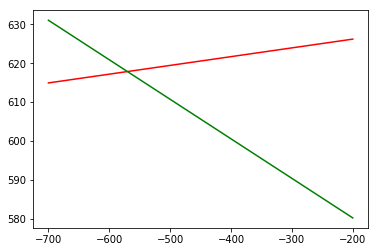

[2, 3] [4, 4]
2


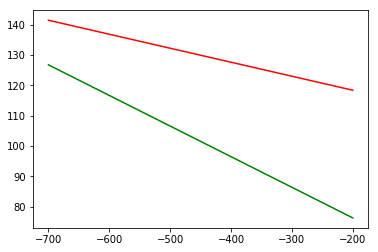

[2, 3] [4, 4]
2


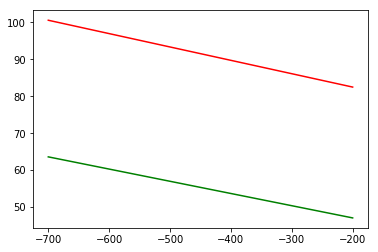

[2, 3] [4, 4]
2


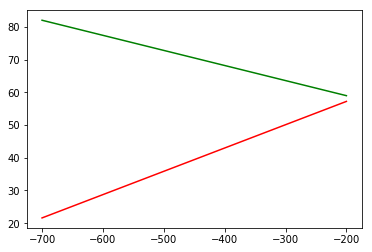

[2, 3] [4, 4]
2


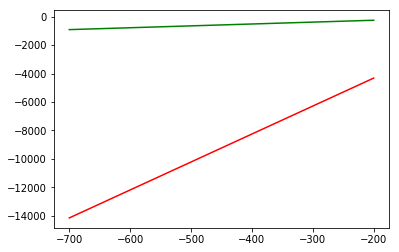

[2, 3] [4, 4]
2


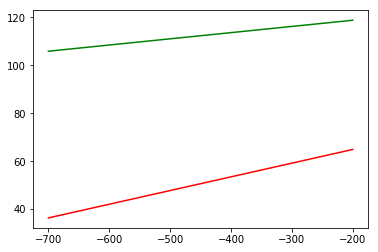

[0, 1] [4, 3]
0


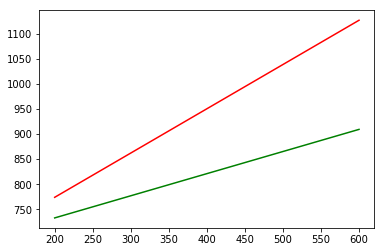

[2, 3] [4, 4]
2


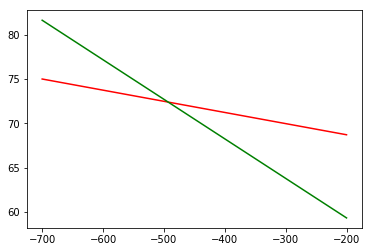

[0, 1] [3, 3]
0


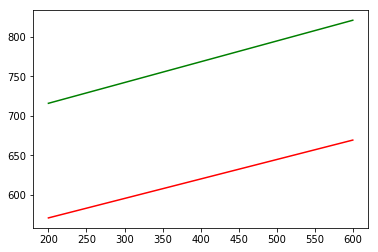

[2, 3] [4, 3]
2


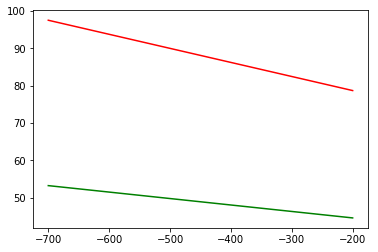

[0, 1] [4, 4]
0


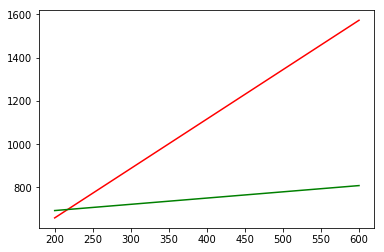

[2, 3] [4, 4]
2


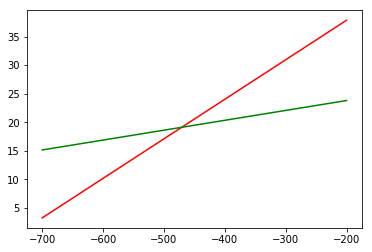

[2, 3] [4, 4]
2


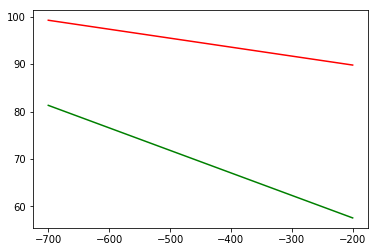

[2, 3] [4, 4]
2


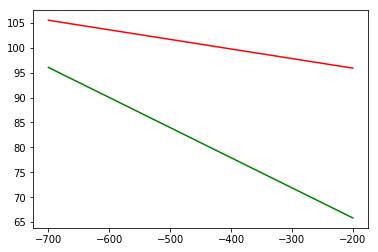

[2, 3] [4, 4]
2


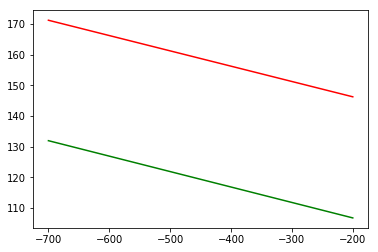

[2, 3] [4, 4]
2


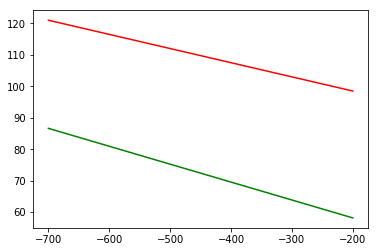

[2, 3] [4, 4]
2


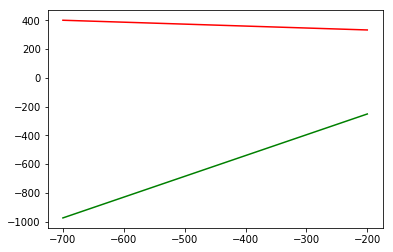

[2, 3] [3, 3]
2


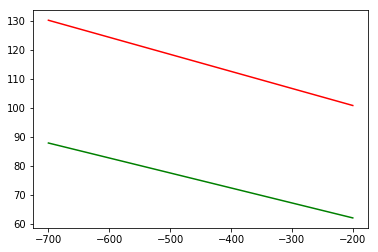

[2, 3] [4, 4]
2


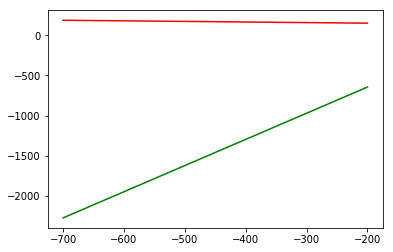

[2, 3] [4, 4]
2


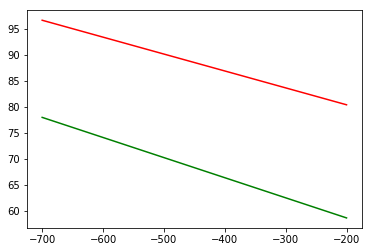

[2, 3] [4, 4]
2


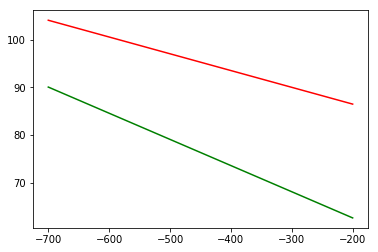

[2, 3] [3, 4]
2


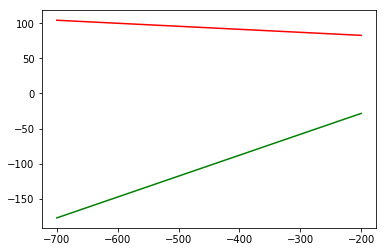

[2, 3] [3, 4]
2


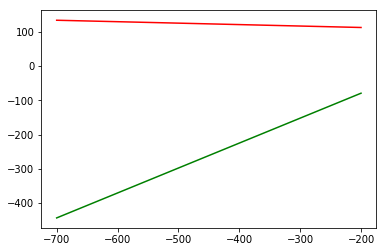

[2, 3] [4, 4]
2


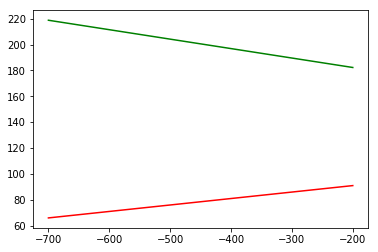

[2, 3] [3, 4]
2


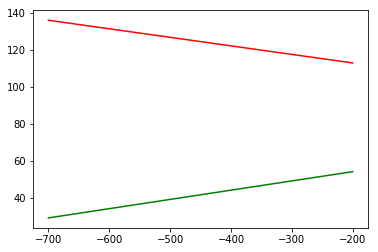

[2, 3] [4, 3]
2


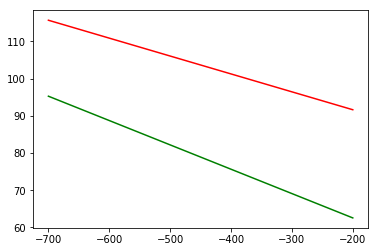

[2, 3] [4, 4]
2


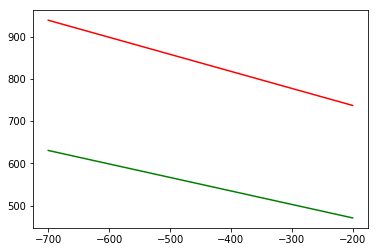

[2, 3] [4, 3]
2


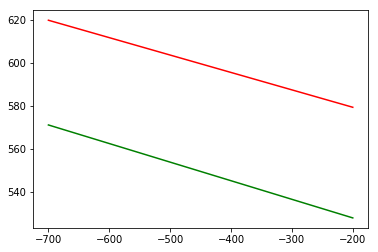

[2, 3] [4, 4]
2


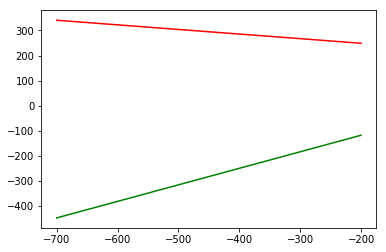

[2, 3] [4, 4]
2


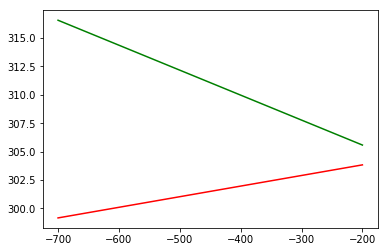

[2, 3] [4, 4]
2


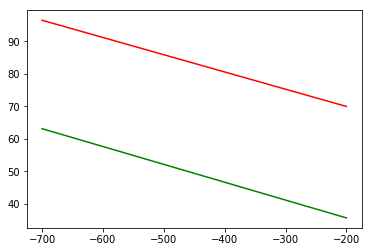

[0, 1] [3, 4]
0


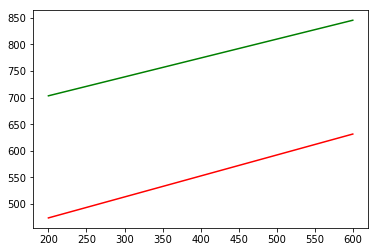

[2, 3] [4, 4]
2


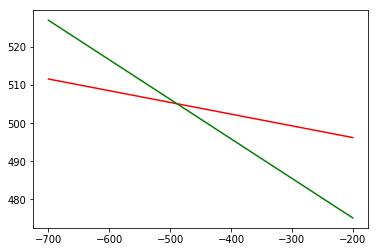

[2, 3] [4, 4]
2


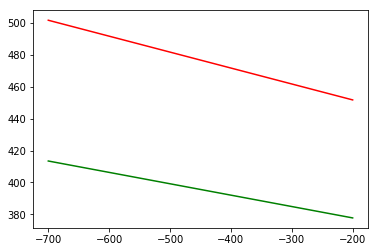

[2, 3] [4, 3]
2


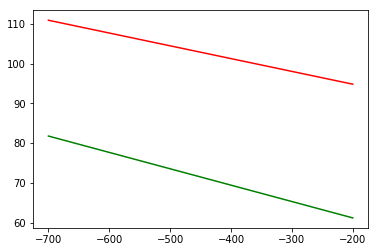

[2, 3] [4, 4]
2


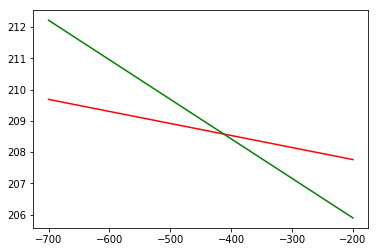

[2, 3] [3, 4]
2


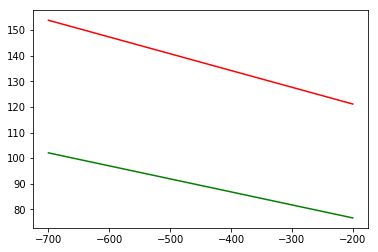

[2, 3] [4, 3]
2


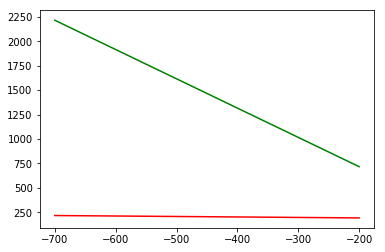

[2, 3] [4, 4]
2


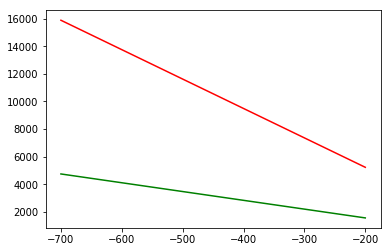

[2, 3] [3, 3]
2


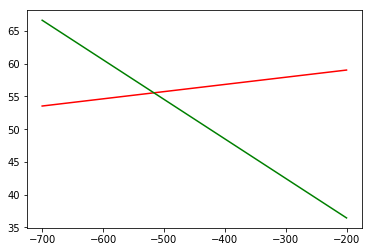

[2, 3] [4, 4]
2


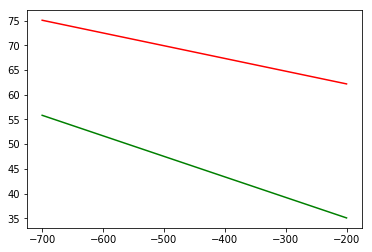

[2, 3] [4, 4]
2


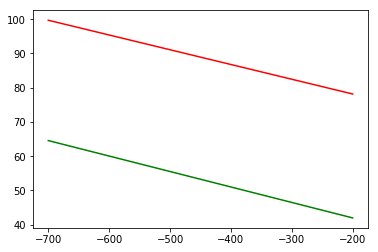

[2, 3] [4, 4]
2


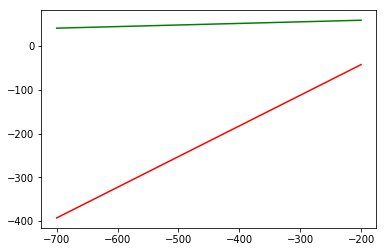

[2, 3] [4, 4]
2


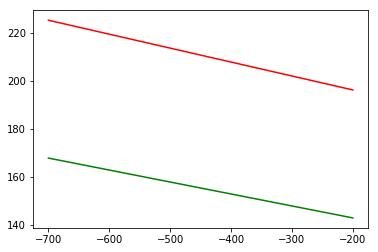

[2, 3] [4, 3]
2


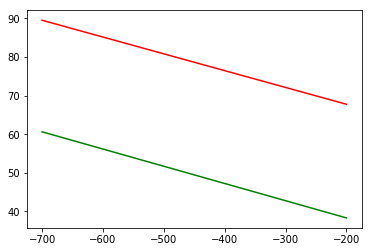

[2, 3] [4, 4]
2


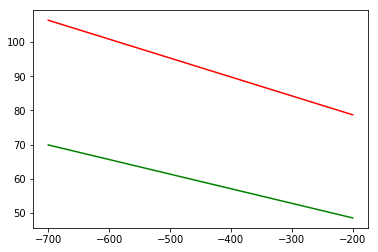

[2, 3] [4, 4]
2


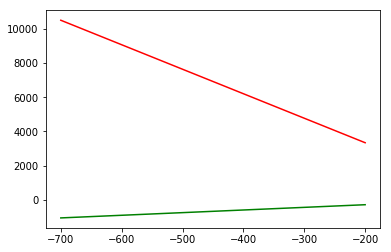

[2, 3] [4, 3]
2


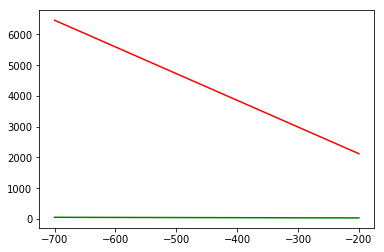

[0, 1] [4, 4]
0


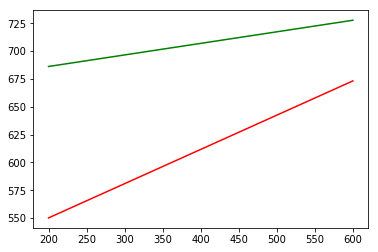

[2, 3] [4, 4]
2


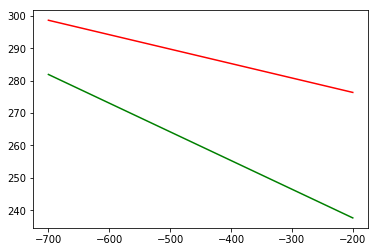

[2, 3] [4, 4]
2


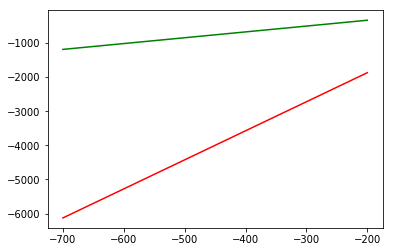

[2, 3] [3, 4]
2


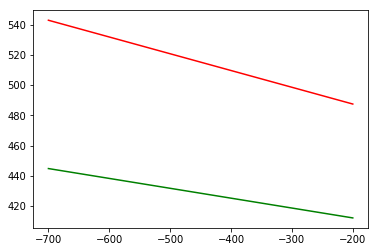

[2, 3] [4, 4]
2


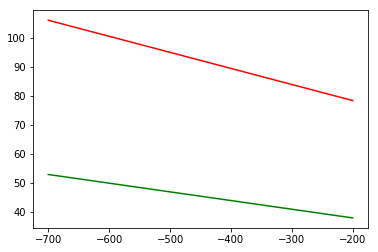

[2, 3] [4, 4]
2


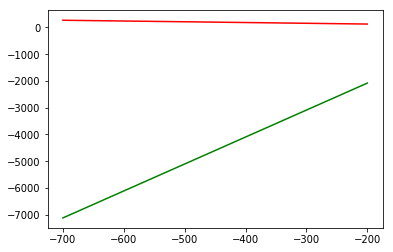

[2, 3] [4, 3]
2


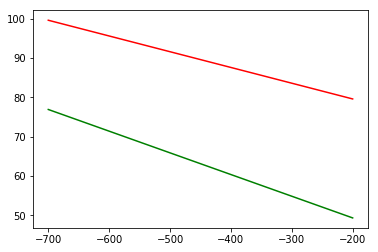

[2, 3] [4, 4]
2


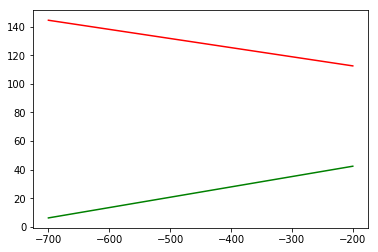

[2, 3] [4, 4]
2


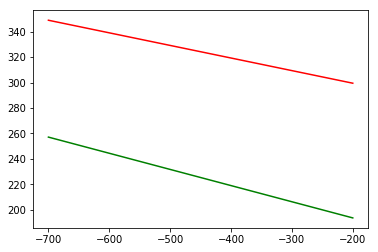

[2, 3] [4, 4]
2


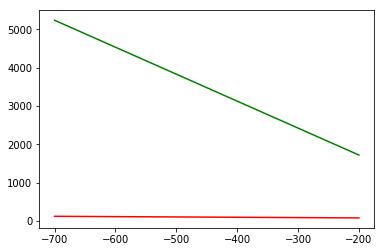

[2, 3] [4, 4]
2


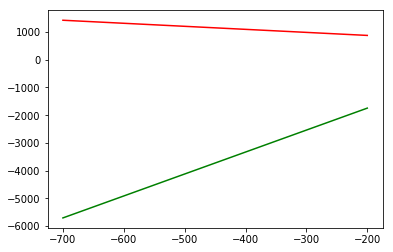

[2, 3] [3, 4]
2


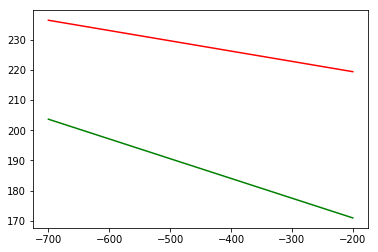

[2, 3] [4, 4]
2


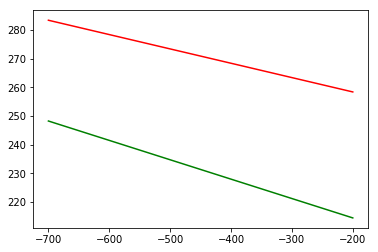

[2, 3] [4, 4]
2


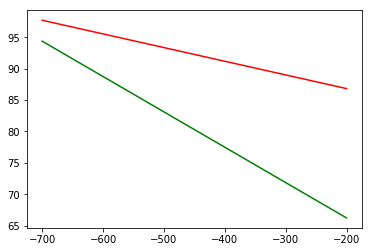

[0, 1] [4, 3]
0


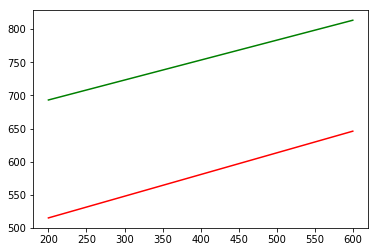

[2, 3] [3, 4]
2


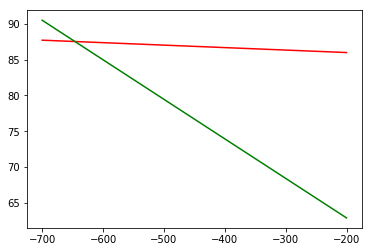

[2, 3] [4, 4]
2


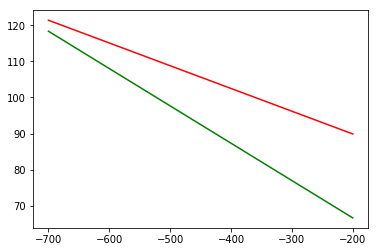

[2, 3] [4, 4]
2


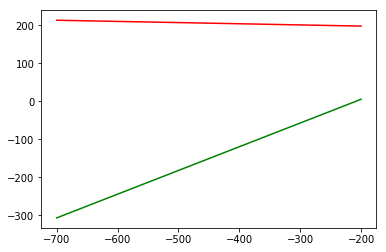

[2, 3] [3, 3]
2


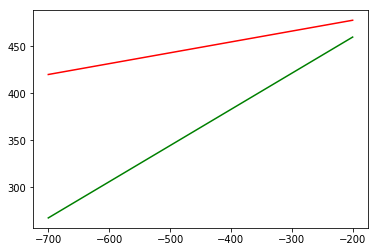

[2, 3] [4, 4]
2


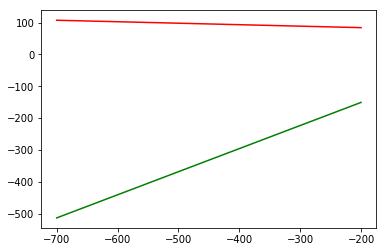

[2, 3] [4, 3]
2


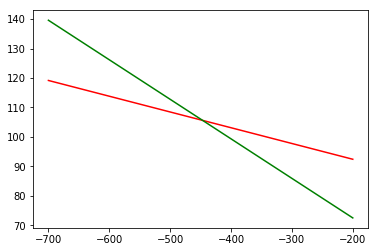

[2, 3] [4, 4]
2


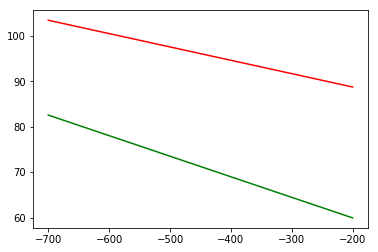

[2, 3] [3, 3]
2


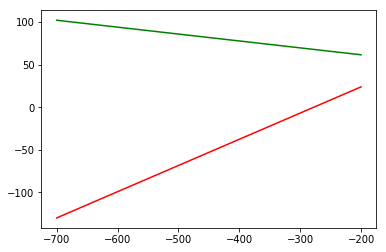

[2, 3] [3, 3]
2


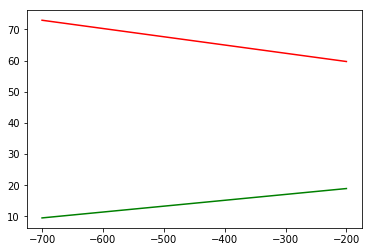

[2, 3] [4, 4]
2


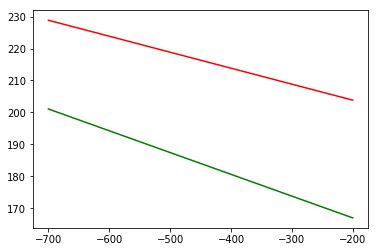

[2, 3] [3, 3]
2


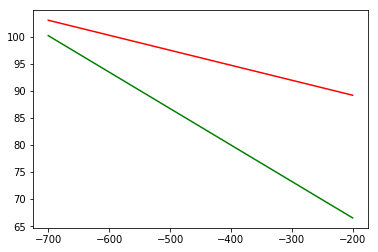

[2, 3] [4, 4]
2


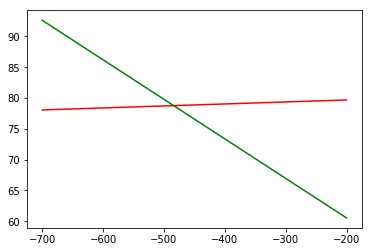

[2, 3] [4, 4]
2


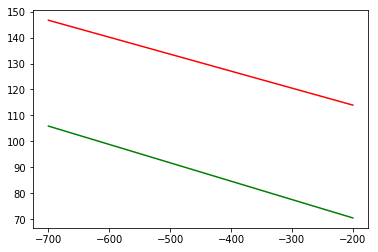

[2, 3] [4, 4]
2


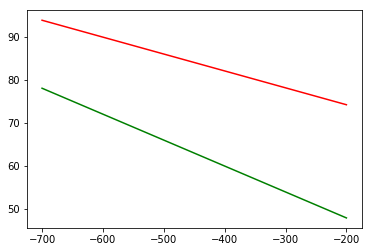

[2, 3] [4, 4]
2


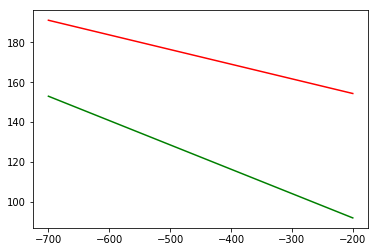

[2, 3] [4, 4]
2


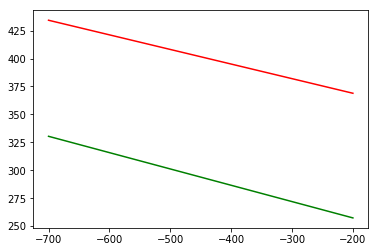

[2, 3] [4, 4]
2


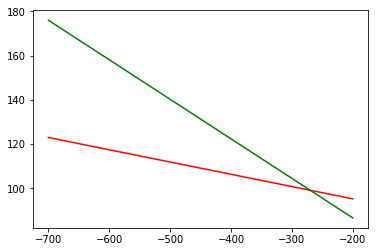

[2, 3] [4, 4]
2


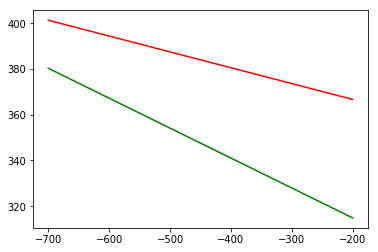

[2, 3] [4, 4]
2


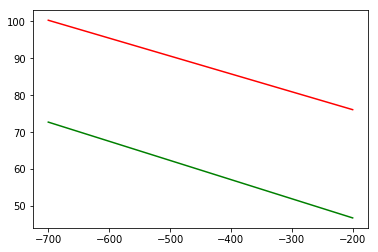

[2, 3] [4, 4]
2


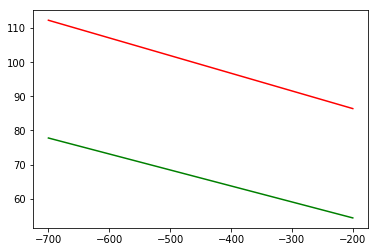

[2, 3] [4, 4]
2


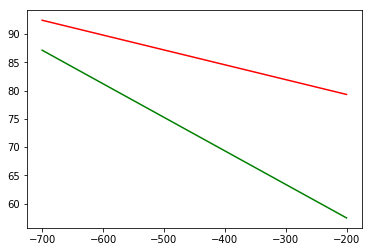

[2, 3] [3, 3]
2


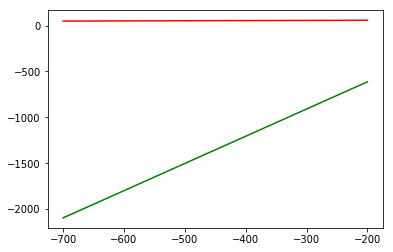

[2, 3] [4, 4]
2


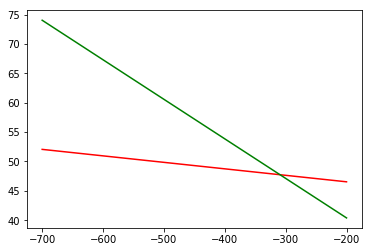

[2, 3] [4, 4]
2


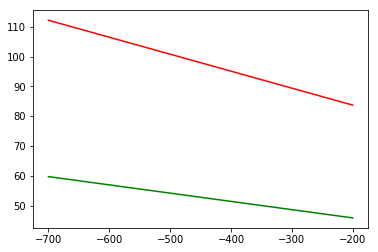

[2, 3] [4, 4]
2


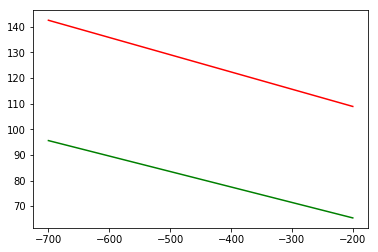

[2, 3] [3, 4]
2


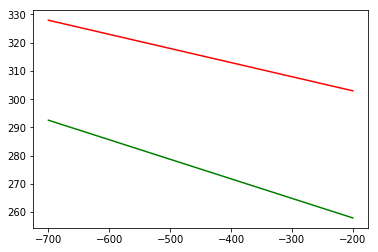

[2, 3] [4, 4]
2


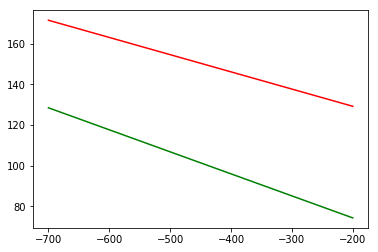

[2, 3] [4, 4]
2


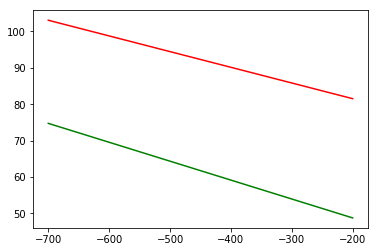

[0, 1] [4, 4]
0


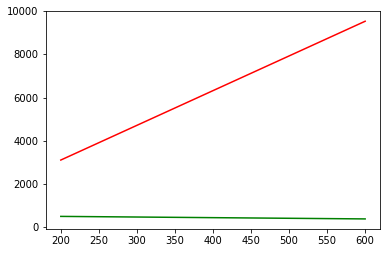

[2, 3] [4, 4]
2


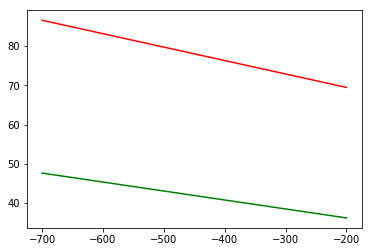

[2, 3] [4, 4]
2


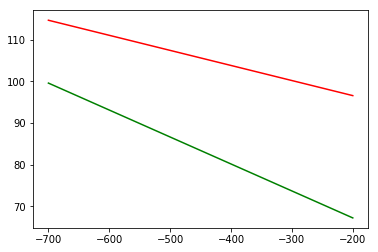

[2, 3] [4, 4]
2


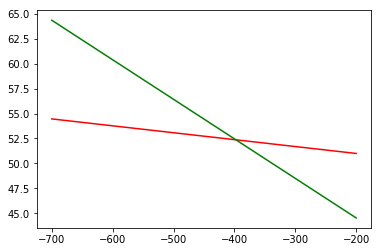

[2, 3] [4, 4]
2


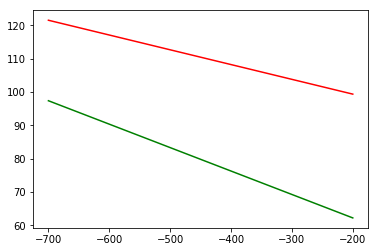

[0, 1] [4, 3]
0


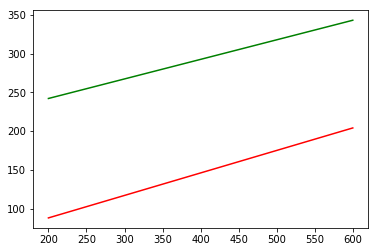

[2, 3] [4, 4]
2


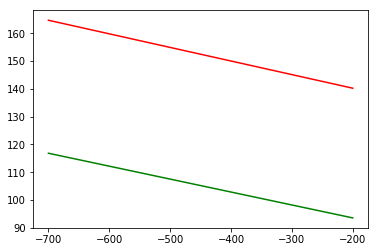

[2, 3] [4, 3]
2


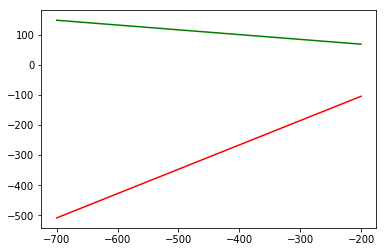

[2, 3] [4, 4]
2


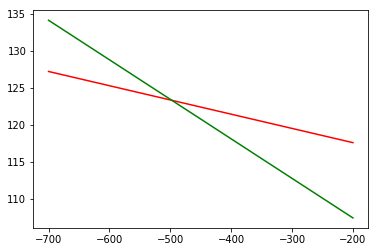

[2, 3] [4, 4]
2


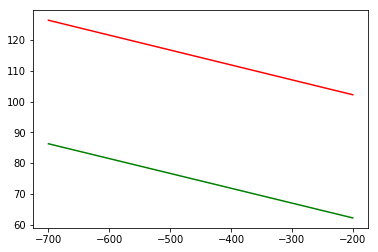

[2, 3] [4, 4]
2


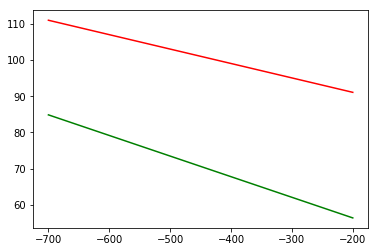

[2, 3] [4, 4]
2


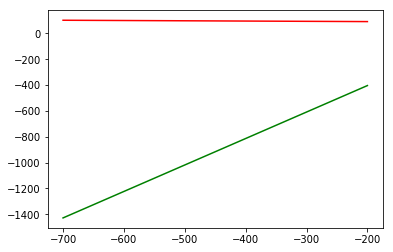

[2, 3] [4, 3]
2


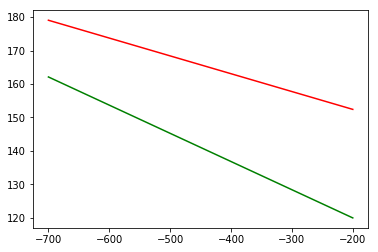

[2, 3] [4, 4]
2


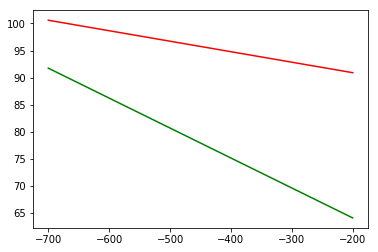

[2, 3] [3, 4]
2


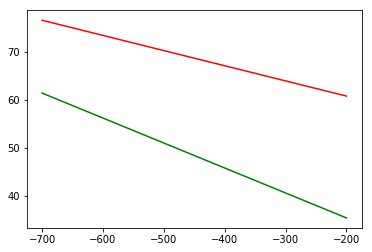

[2, 3] [4, 4]
2


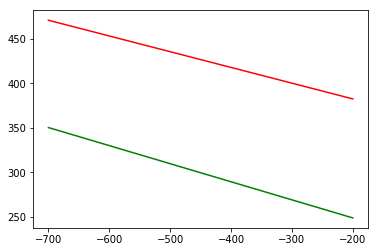

[2, 3] [4, 4]
2


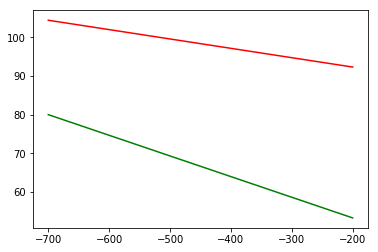

[2, 3] [4, 4]
2


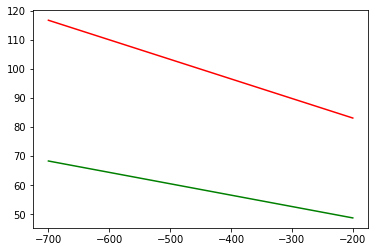

[0, 1] [3, 4]
0


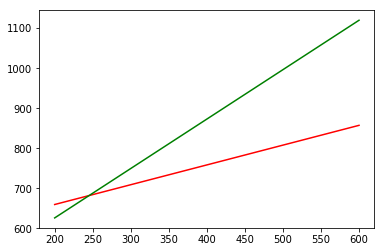

[2, 3] [4, 4]
2


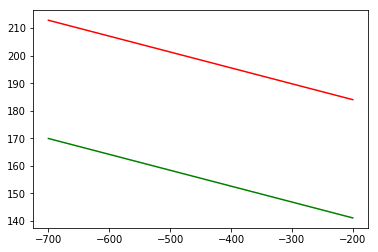

[2, 3] [4, 4]
2


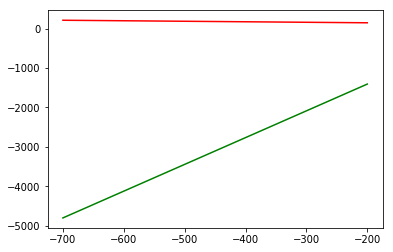

[2, 3] [4, 4]
2


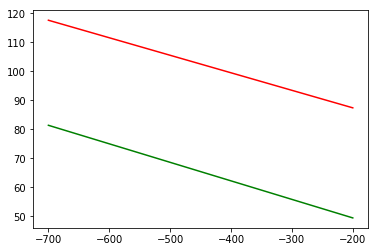

[2, 3] [4, 4]
2


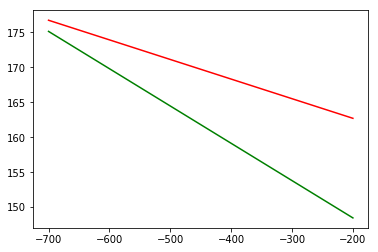

[2, 3] [4, 4]
2


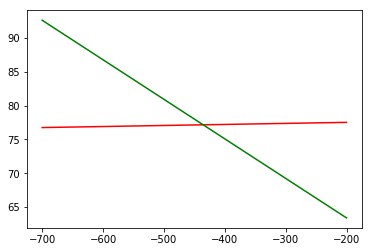

[2, 3] [4, 4]
2


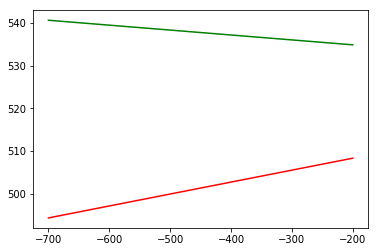

[2, 3] [4, 4]
2


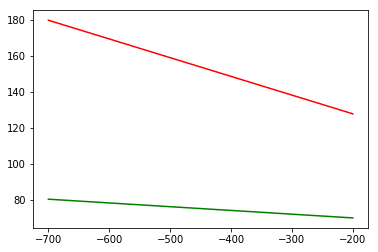

[2, 3] [4, 4]
2


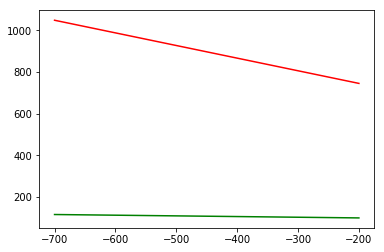

[2, 3] [4, 4]
2


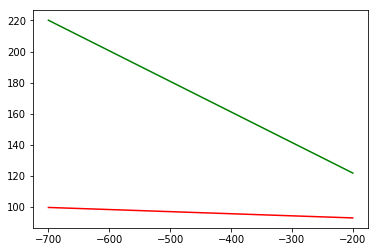

[2, 3] [4, 4]
2


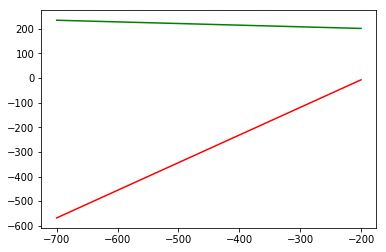

[2, 3] [3, 4]
2


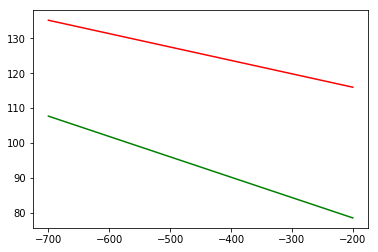

[2, 3] [4, 4]
2


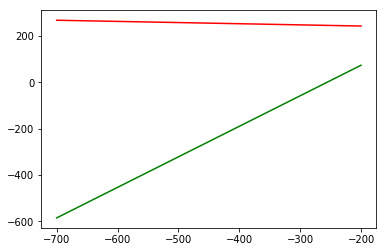

[2, 3] [4, 3]
2


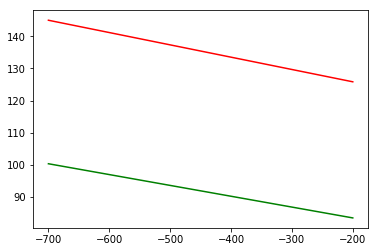

[2, 3] [4, 4]
2


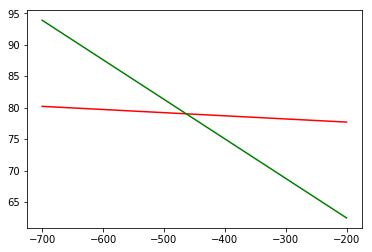

[2, 3] [4, 3]
2


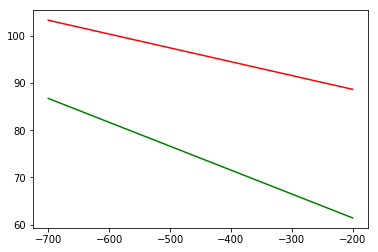

[2, 3] [4, 4]
2


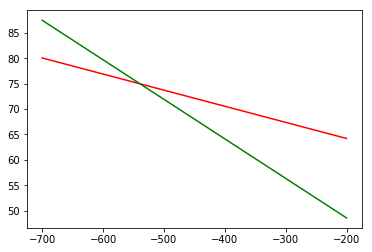

[2, 3] [4, 4]
2


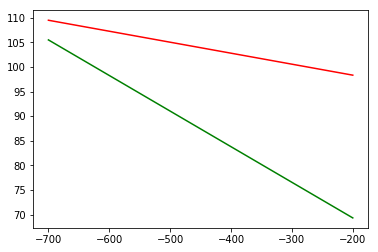

[2, 3] [4, 3]
2


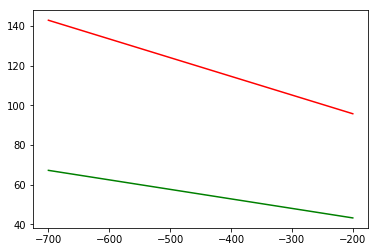

[2, 3] [4, 4]
2


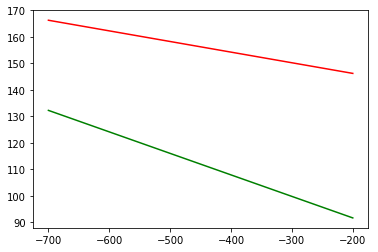

[2, 3] [4, 4]
2


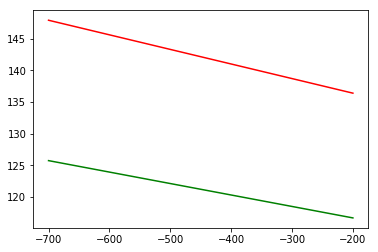

[2, 3] [4, 3]
2


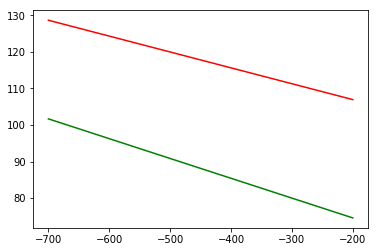

[2, 3] [4, 4]
2


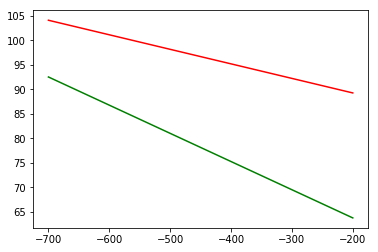

[2, 3] [3, 4]
2


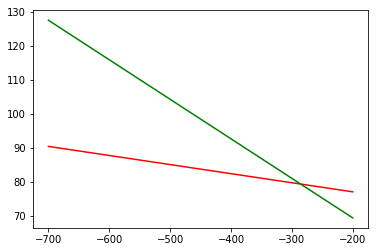

[2, 3] [4, 4]
2


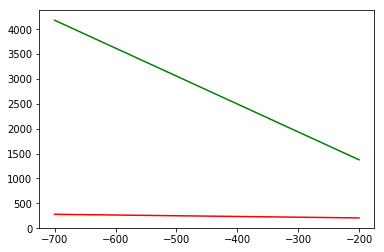

[2, 3] [4, 4]
2


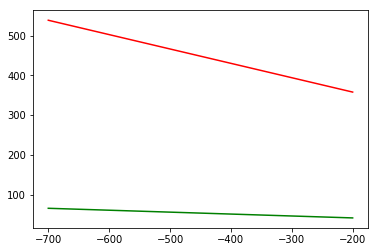

[2, 3] [4, 4]
2


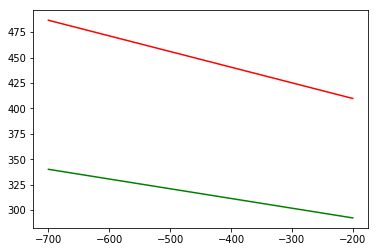

[2, 3] [4, 3]
2


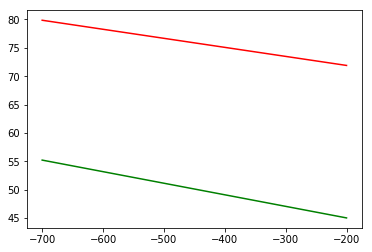

[2, 3] [4, 4]
2


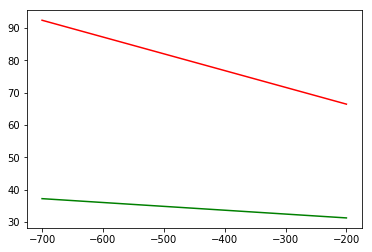

[2, 3] [4, 4]
2


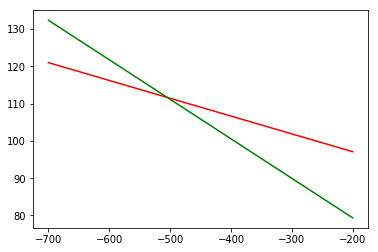

[2, 3] [4, 4]
2


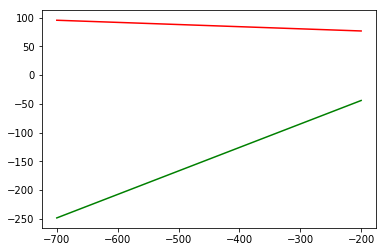

[2, 3] [4, 4]
2


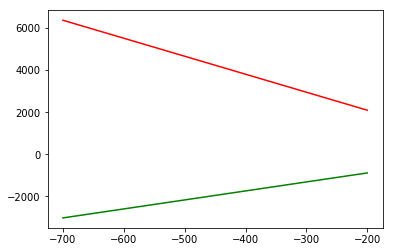

[2, 3] [4, 4]
2


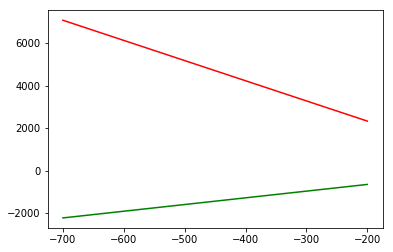

[2, 3] [4, 3]
2


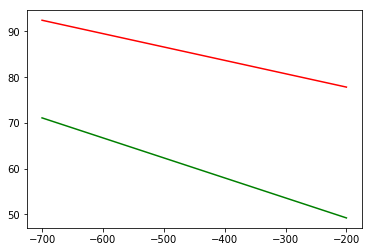

[2, 3] [3, 3]
2


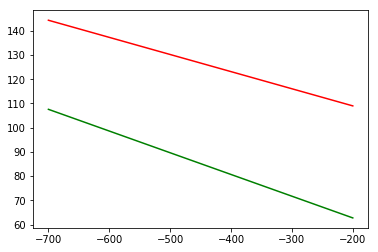

In [ ]:
'''ERRORE SISTEMATICO NEL POSIZIONAMENTO DELLE CAMERE'''

def read_data(event):    
    event_number = int(event[0])
    hits_number  = int(event[1])
    hit       = np.arange(hits_number)
    chamber   = np.fromiter((event[2+5*i] for i in range(hits_number)), int)
    layer     = np.fromiter((event[3+5*i] for i in range(hits_number)), int)
    xl_local  = np.fromiter((event[4+5*i] for i in range(hits_number)), float)
    xr_local  = np.fromiter((event[5+5*i] for i in range(hits_number)), float)
    z_local   = np.fromiter((local_z_shifts[i-1]+ZCELL/2 for i in layer), float)
    time      = np.fromiter((event[6+5*i] for i in range(hits_number)), float)
    xl_global = np.fromiter((global_x_shifts[i] for i in chamber), float) - xl_local
    xr_global = np.fromiter((global_x_shifts[i] for i in chamber), float) - xr_local
    z_global  = np.fromiter((global_z_shifts[i] for i in chamber), float) + z_local
    dataframe = pd.DataFrame(
        { 'EvNumber' : event_number,
          'Hit'      : hit,
          'Chamber'  : chamber,
          'Layer'    : layer,
          'XL_local' : xl_local,
          'XR_local' : xr_local,
          'Z_local'  : z_local,
          'Time'     : time,
          'XL_global': xl_global,
          'XR_global': xr_global,
          'Z_global' : z_global,
        })
    #dataframe.set_index('Hit', inplace=True) # set as index the number of the hit 
    return dataframe, event_number, hits_number


def select_events(dataframe):
        
        #hits only in the right side
        if((dataframe['Chamber']<=1).all()):
            chambers=[0,1]
            #compute number of different layers in each chamber
            n_layer_ch0 = dataframe[dataframe['Chamber']==0]['Layer'].nunique()
            n_layer_ch1 = dataframe[dataframe['Chamber']==1]['Layer'].nunique()
            
            n_layer=[n_layer_ch0, n_layer_ch1]
            
            #require at least 3 different layers for each chamber
            if(n_layer_ch0>=3 and n_layer_ch1>=3):
                select=True
                return select, chambers, n_layer
            else:
                select=False
                return select, chambers, n_layer
            
        #hits only in the left side
        elif((dataframe['Chamber']>=2).all()):
            chambers=[2,3]
            #compute number of different layers in each chamber
            n_layer_ch2 = dataframe[dataframe['Chamber']==2]['Layer'].nunique()
            n_layer_ch3 = dataframe[dataframe['Chamber']==3]['Layer'].nunique() 
            
            n_layer=[n_layer_ch2, n_layer_ch3]
            
            #require at least 3 different layers for each chamber
            if(n_layer_ch2>=3 and n_layer_ch3>=3):
                select=True
                return select, chambers, n_layer
            else:
                select=False
                return select, chambers, n_layer
        
        #hits in both left and right side
        else:
            select=False
            chambers=[]
            n_layer=[]
            return select, chambers, n_layer 



def local_fit(dataframe, list_chambers, list_layers):
    #list to store results for each chamber
    results=[]
    #loop over the (two) chambers
    for i in range(0,len(list_chambers)):
       #if we have 4 different layers we randomly select a layer to be excluded
       #we will use the point from the excluded layer to check the goodness of the global fit
        if(list_layers[i]==4):
            rand_layer=random.randint(1,4)
        else:
            rand_layer=0 #layers are 1,2,3,4: excluding layer 0 is equivalent to keeping them all
        
        #create dataframe_cl filtered by chamber and excluded layer
        dataframe_c = dataframe[dataframe['Chamber']==list_chambers[i]] #dataframe filtered by chamber
        dataframe_cl = dataframe_c[dataframe_c['Layer']!=rand_layer]    #filtered by chamber and excluded layer
        
        # Z local coordinates corresponding to the 4 different layers
        Z=[6.5,19.5, 32.5, 45.5]
        
        #create a list l containing 3 lists of points (z,x), one for each selected layer
        l=[]
        
        #loop over selected layers and fill l
        for layer_index in dataframe_cl['Layer'].unique():
            XR=np.array(dataframe_cl[dataframe_cl['Layer']==layer_index]['XR_local'])
            XL=np.array(dataframe_cl[dataframe_cl['Layer']==layer_index]['XL_local'])
            
            z=Z[(layer_index-1)] #layer_index is in range [1,4], list index must be in range [0,3]
            l_temp=[]
            
            for x in XR:
                l_temp.append((z,x))
            for x in XL:
                l_temp.append((z,x)) 
            l.append(l_temp) 
            
        #create numpy array with all possible combinations of 3 points p1,p2,p3
        combinations=np.array([(p1,p2,p3) for p1 in l[0] for p2 in l[1] for p3 in l[2]])
        
        #interpolate each combination and select the combination with least chi squared
        min_chisq=100000 #to store minimum chisq
        optimal_comb=np.zeros((3,2)) #to store best combination of points
        slope_opt=0 #to store slope obtained with the best combination
        intercept_opt=0 #to store intercept obtained with the best combination
        for points in combinations:
            #linear regression
            slope, intercept, r_value, p_value, std_err=stats.linregress(points[:,0],points[:,1])
            #compute expected x using the interpolating function
            expect_x=intercept+slope*(points[:,0])
            #compute chi squared
            chisq, p_value=stats.chisquare(points[:,1],expect_x)
            #eventually update min_chisq and optimal_comb
            if(chisq<min_chisq):
                min_chisq=chisq
                optimal_comb=points
                slope_opt=slope
                intercept_opt=intercept
            else:
                continue
                  
        #add to results: results is a list of 2 dictionaries, one for each chamber       
        results.append({"slope":slope_opt, 
                        "intercept":intercept_opt, 
                        "optimal_comb": optimal_comb, 
                        "excl_layer": rand_layer})
                   
    return results




for i in listdir("/Users/federicob/Documents/data/calibration/Run000260"):
    file="/Users/federicob/Documents/data/calibration/Run000260"+"/"+i 
    
    with open(file) as f:
        for line in f:
            event = line.split()
            event = [float(i) for i in event]
            
            
            
            dataframe, event_number, hits_number=read_data(event) 
            #print(dataframe)
            
            if select_events(dataframe)[0]==True:
                
                #print(dataframe)# mi sono selezionato gli eventi
                condition, chambers, n_layers=select_events(dataframe)
                print(chambers,n_layers)
                print(chambers[0])
                
                '''adesso devo eseguire i local linear fit della camera sopra e della camera sotto'''
                lf_results=local_fit(dataframe, chambers, n_layers)

                plt.figure()
                if chambers[0]==2:
                    x=np.linspace(-700,-200,100)
                    y=lf_results[0]["slope"]*x+lf_results[0]["intercept"]
                    plt.plot(x,y,color="red")
                    y=lf_results[1]["slope"]*x+lf_results[1]["intercept"]
                    plt.plot(x,y,color="green")
                    
                else:
                    x=np.linspace(200,600,100)
                    y=lf_results[0]["slope"]*x+lf_results[0]["intercept"]
                    plt.plot(x,y,color="red")
                    y=lf_results[1]["slope"]*x+lf_results[1]["intercept"]
                    plt.plot(x,y,color="green")
                    
                plt.show()
                
                
            





